In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier,RadiusNeighborsClassifier

from sklearn.model_selection import train_test_split 

from sklearn.metrics import classification_report,f1_score

from sklearn.preprocessing import RobustScaler, QuantileTransformer, MinMaxScaler, MaxAbsScaler, LabelEncoder

from sklearn.impute import SimpleImputer

from sklearn.pipeline import make_pipeline

from sklearn.model_selection import GridSearchCV,RandomizedSearchCV


## loading dataset

In [2]:
wine=pd.read_csv('redwine quality.csv')
wine.quality=LabelEncoder().fit_transform(wine.quality)
wine

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [4]:
wine.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [5]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


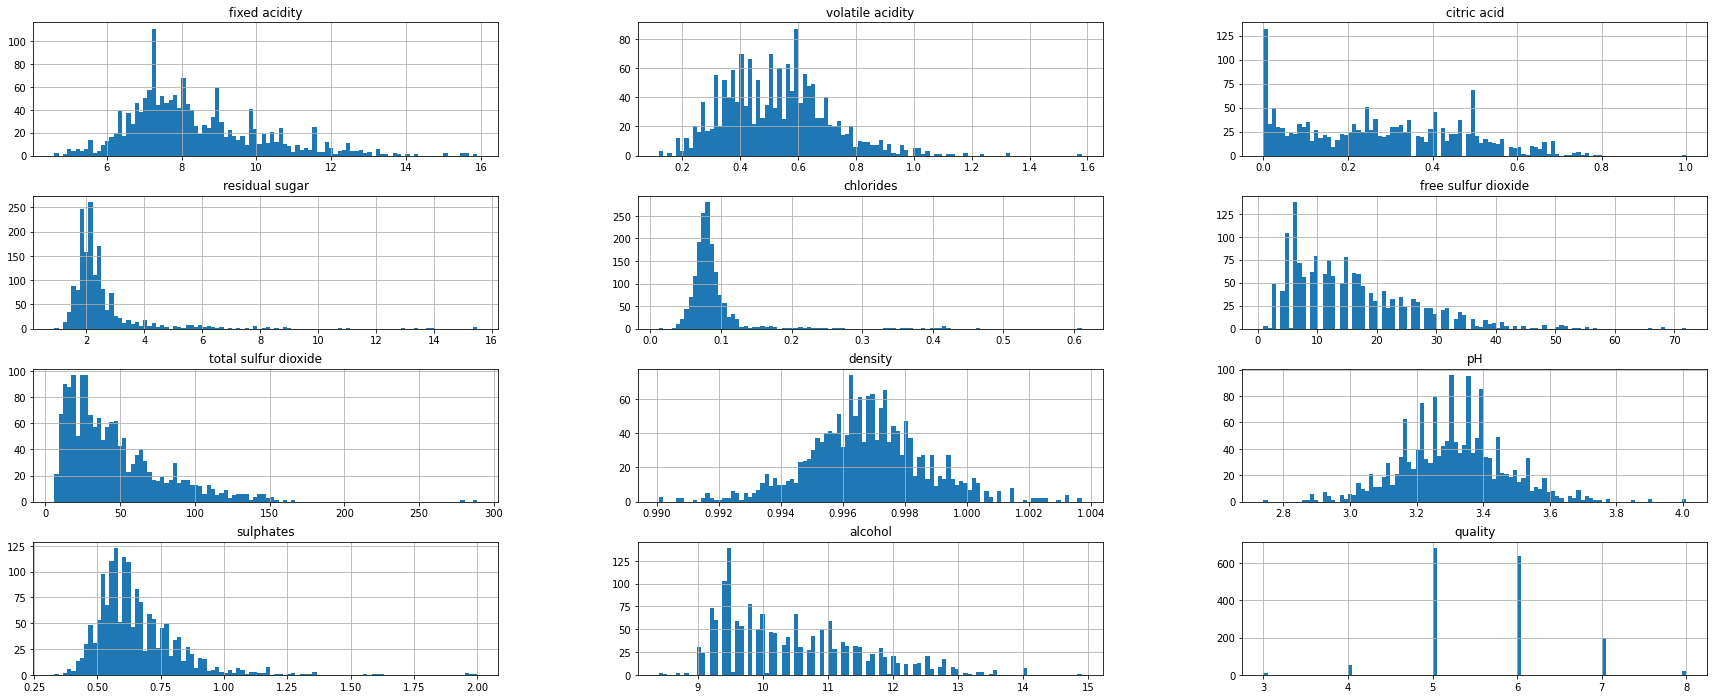

In [6]:
wine.hist(figsize=(30,12),bins=100)
plt.show()

## FUNCTIONS to check and remove outliers

#### 5 point summary fn

In [8]:
def five_point(column):
    print('5 point summary:')
    print(pd.DataFrame(column).describe().iloc[3:] )
    print('---------------------------------')

#### Z score fn

In [9]:
def z_score(column):
    
    mean=np.mean(column)
    stdev=np.std(column)
    
    with_z=pd.DataFrame( {
                            'outliers' : column,
                            'Z-score' : (column-mean)/stdev 
    })
    
    lower=-3*stdev+mean
    upper=3*stdev+mean
    
    print( 'OUTLIERS in '+column.name.upper()+' via Z score\n' )
    print('Outlier limits:\nlower limit:',lower,'\nupper limit:',upper)
    print()
    
    outliers=with_z[ abs( with_z['Z-score'] )>3 ]          # observations with absolute value of z-score greater than 3 are considered outliers
    
    print('Total outliers:',len(outliers))
    print( outliers )
    print('---------------------------------')

#### IQR fn

In [10]:
def IQR_method(column):
    
    print( 'OUTLIERS in '+column.name.upper()+' via IQR\n' )
    
    #extracting q1,q3 from df.describe
    q1,q3=column.describe().iloc[[4,6]]
    
    #upper and lower limit using iqr
    iqr=q3-q1
    upper=q3+1.5*iqr
    lower=q1-1.5*iqr
    
    print('Outlier limits:\nlower limit:',lower,'\nupper limit:',upper)            # outlier limits defined using quartiles, iqr and tukey value of 1.5
    print()
    
    outliers=pd.DataFrame( {
                            'outliers' : column[(column<lower) | (column>upper) ]
    })
    
    print('Total outliers:',len(outliers))
    print( outliers )
    print('---------------------------------')
    

#### Analysis of quantitative columns fn

In [11]:
def analysis_quant(column):
    print('\t\t\t\tANALYSIS OF:',column.name.upper(),'\n')

    five_point(column)      # five point summary
    z_score(column)         # z score and outliers
    IQR_method(column)      # iqr and outliers using boxplot
    
    print('\t\t\t\t\t\t\t\t\t\tVISUALISATION\n\t\t\t\tBOXPLOT\t\t\t\t\t\t\t\t\t\t\t\tHISTOGRAM')
    
    fig, axes = plt.subplots(1, 2, sharex=True, figsize=(20,7),dpi=300)
    sns.boxplot(ax=axes[0] , x=column)                       # boxplot
    sns.histplot(ax=axes[1],data=column,bins=25)             # histogram
    plt.show()
    
    print('_____________________________________________________________________________________________________________________')

#### Remove outliers fn

In [12]:
def remove_outliers(df,column,using='IQR'):
    
    '''Remove outliers from dataframe by using either IQR or Z
       Parameters: df: a pandas dataframe
                   column: column(name) from which outliers are to be removed
                   using: by default 'IQR' is used. Other option is 'Z'
    '''
    
    if using.upper()=='IQR':
        
        #extracting q1,q3 from df.describe
        q1,q3=df[column].describe().iloc[[4,6]]

        #upper and lower limit using iqr
        iqr=q3-q1
        upper=q3+1.5*iqr
        lower=q1-1.5*iqr
        
        outliers=pd.DataFrame( { 'outliers' : df[column][(df[column]<lower) | (df[column]>upper)] } )
        df.drop(index=outliers.index, inplace=True)
        print('Removed the following outliers:\n',outliers)
        
        
    if using.upper()=='Z':
        
        mean=np.mean(df[column])
        stdev=np.std(df[column])

        with_z=pd.DataFrame( {'outliers' : df[column], 'Z-score' : (df[column]-mean)/stdev  })

        lower=-3*stdev+mean
        upper=3*stdev+mean

        outliers=with_z[ abs( with_z['Z-score'] )>3 ]
        df.drop(index=outliers.index, inplace=True)
        print('Removed the following outliers:\n',outliers)


#### Compress outliers fn

In [13]:
def compress_outliers(df,column,using='IQR'):
    
    '''Compress outliers from dataframe into extreme ends of the data by using either IQR or Z
       Parameters: df: a pandas dataframe
                   column: column(name) from which outliers are to be removed
                   using: by default 'IQR' is used. Other option is 'Z'
    '''
    
    if using.upper()=='IQR':
        
        #extracting q1,q3 from df.describe
        q1,q3=df[column].describe().iloc[[4,6]]

        #upper and lower limit using iqr
        iqr=q3-q1
        upper=q3+1.5*iqr
        lower=q1-1.5*iqr
        
        outliers=pd.DataFrame( { 'outliers' : df[column][(df[column]<lower) | (df[column]>upper)] } )
        df.loc[ df[column] > upper, column] = upper
        df.loc[ df[column] < lower, column] = lower
        print('Compressed the following outliers:\n',outliers)
        
        
    if using.upper()=='Z':
        
        mean=np.mean(df[column])
        stdev=np.std(df[column])

        with_z=pd.DataFrame( {'outliers' : df[column], 'Z-score' : (df[column]-mean)/stdev  })

        lower=-3*stdev+mean
        upper=3*stdev+mean

        outliers=with_z[ abs( with_z['Z-score'] )>3 ]
        df.loc[ df[column] > upper, column] = upper
        df.loc[ df[column] < lower, column] = lower
        print('Compressed the following outliers:\n',outliers)


## Analysis of outliers

				ANALYSIS OF: FIXED ACIDITY 

5 point summary:
     fixed acidity
min            4.6
25%            7.1
50%            7.9
75%            9.2
max           15.9
---------------------------------
OUTLIERS in FIXED ACIDITY via Z score

Outlier limits:
lower limit: 3.097981872964991 
upper limit: 13.541292673626629

Total outliers: 12
     outliers   Z-score
243      15.0  3.838072
244      15.0  3.838072
347      13.8  3.148635
374      14.0  3.263541
381      13.7  3.091182
391      13.7  3.091182
442      15.6  4.182790
544      14.3  3.435900
554      15.5  4.125337
555      15.5  4.125337
557      15.6  4.182790
652      15.9  4.355149
---------------------------------
OUTLIERS in FIXED ACIDITY via IQR

Outlier limits:
lower limit: 3.95 
upper limit: 12.349999999999998

Total outliers: 49
      outliers
205       12.8
206       12.8
243       15.0
244       15.0
264       12.5
294       13.3
328       13.4
338       12.4
339       12.5
347       13.8
353       13.5
359       12.6


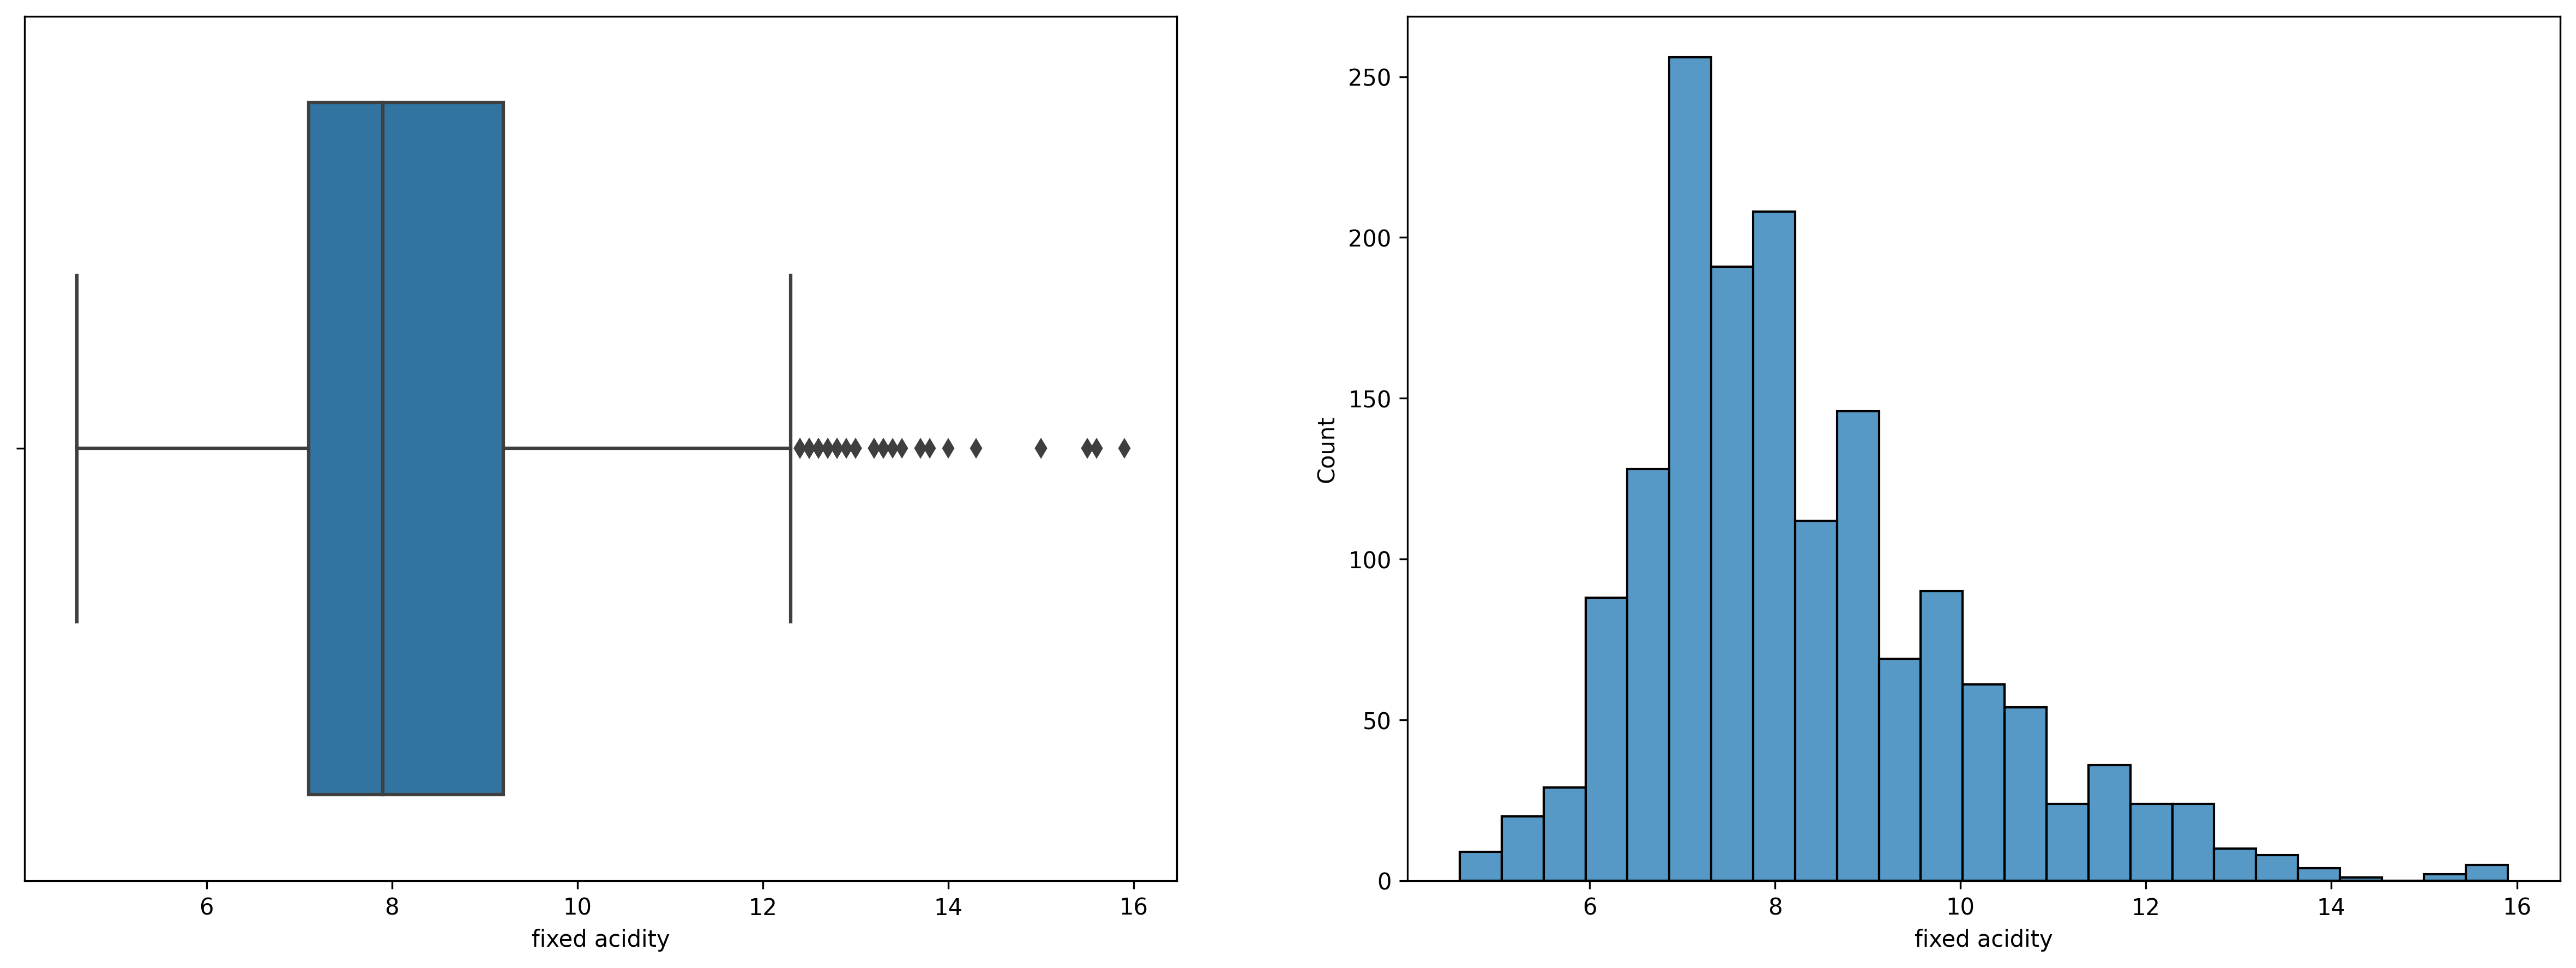

_____________________________________________________________________________________________________________________
				ANALYSIS OF: VOLATILE ACIDITY 

5 point summary:
     volatile acidity
min              0.12
25%              0.39
50%              0.52
75%              0.64
max              1.58
---------------------------------
OUTLIERS in VOLATILE ACIDITY via Z score

Outlier limits:
lower limit: -0.00919059991355764 
upper limit: 1.064831625554583

Total outliers: 10
      outliers   Z-score
38       1.130  3.364062
120      1.070  3.028873
126      1.330  4.481357
127      1.330  4.481357
199      1.090  3.140603
672      1.240  3.978574
690      1.185  3.671318
724      1.115  3.280264
1299     1.580  5.877976
1312     1.180  3.643385
---------------------------------
OUTLIERS in VOLATILE ACIDITY via IQR

Outlier limits:
lower limit: 0.015000000000000013 
upper limit: 1.0150000000000001

Total outliers: 19
      outliers
38       1.130
94       1.020
120      1.070
126      

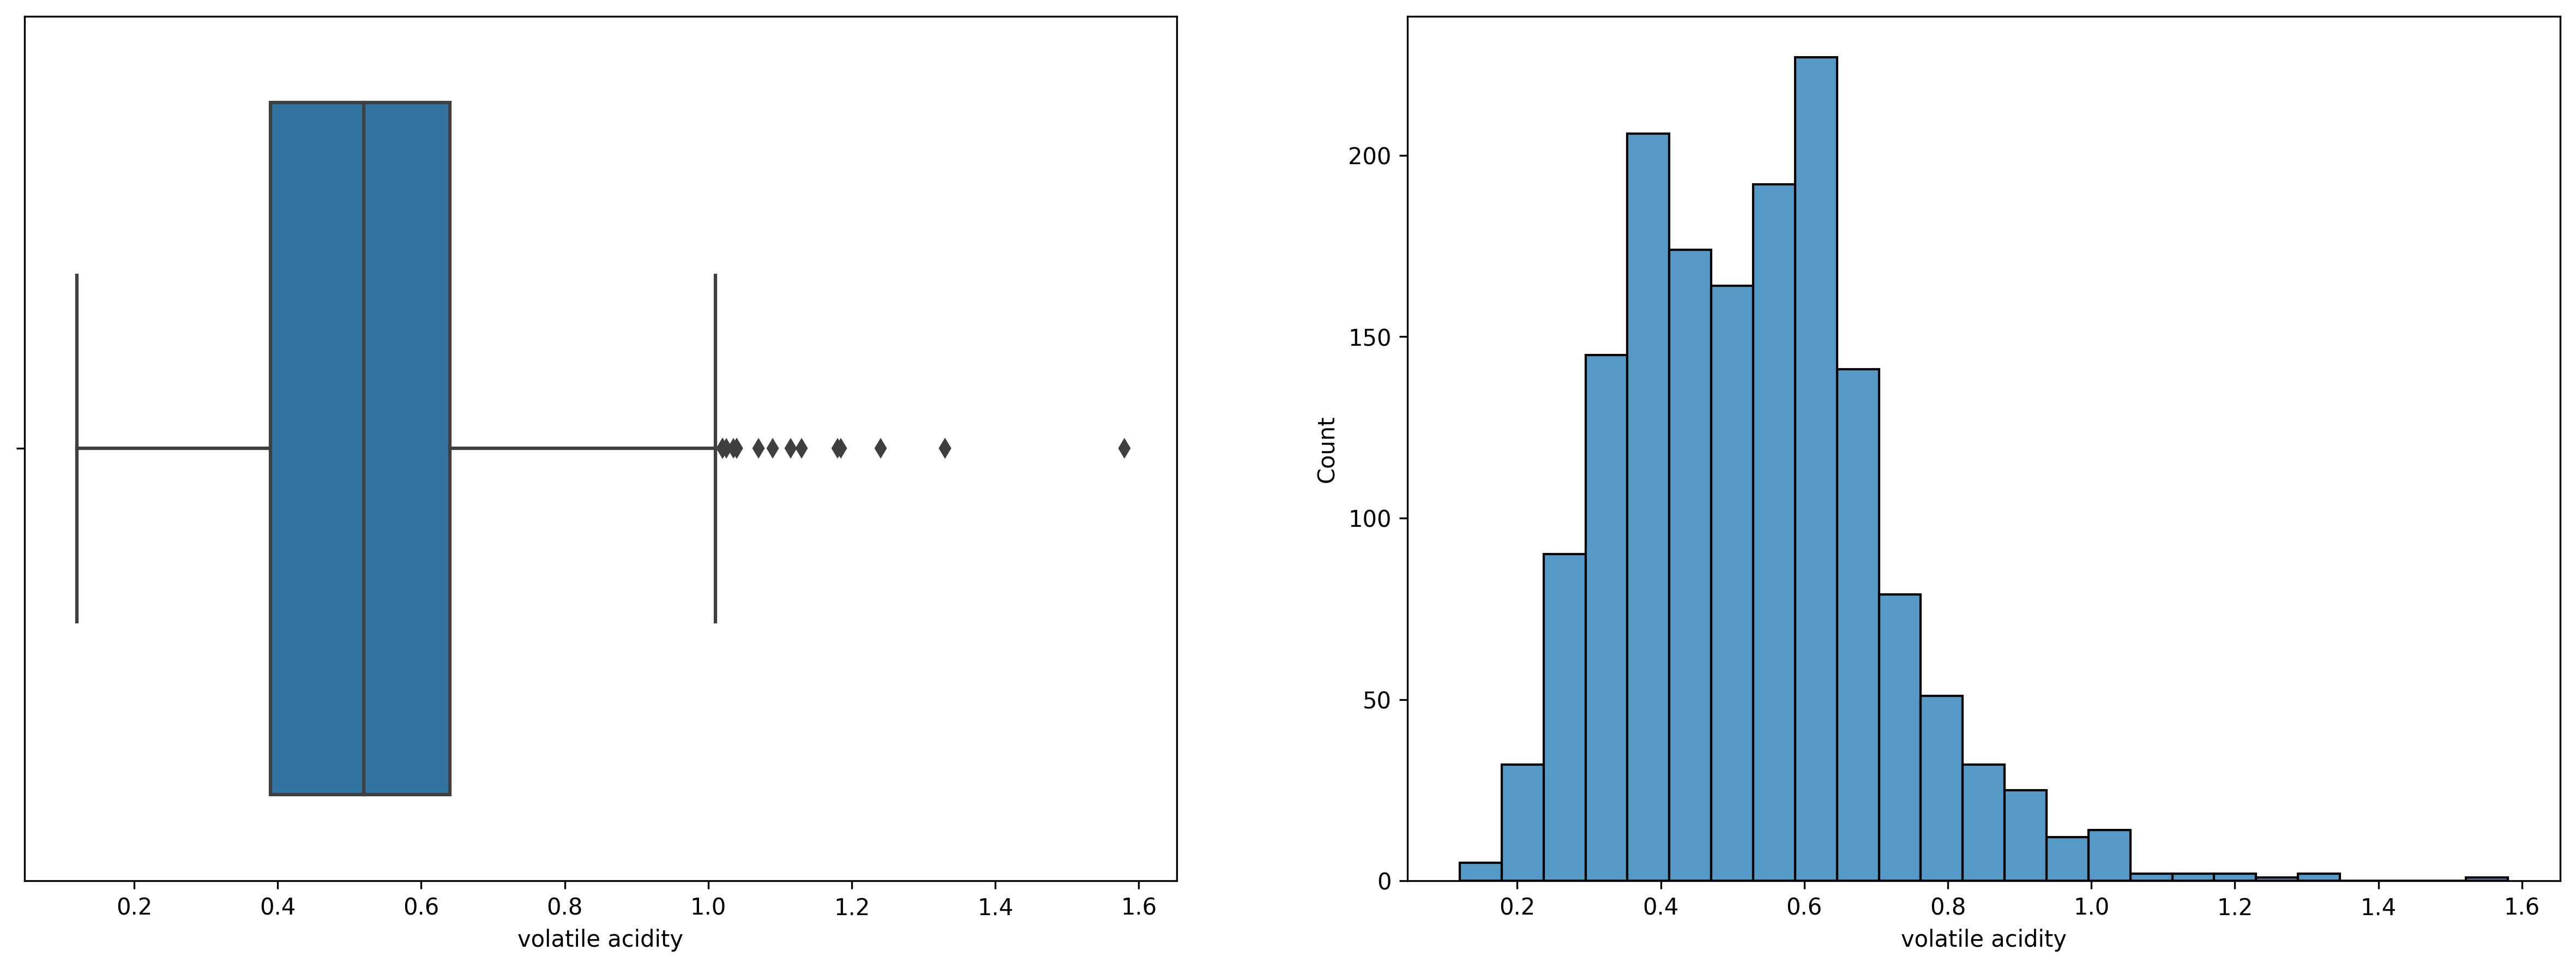

_____________________________________________________________________________________________________________________
				ANALYSIS OF: CITRIC ACID 

5 point summary:
     citric acid
min         0.00
25%         0.09
50%         0.26
75%         0.42
max         1.00
---------------------------------
OUTLIERS in CITRIC ACID via Z score

Outlier limits:
lower limit: -0.3132450336009034 
upper limit: 0.8551962531130985

Total outliers: 1
     outliers   Z-score
151       1.0  3.743574
---------------------------------
OUTLIERS in CITRIC ACID via IQR

Outlier limits:
lower limit: -0.4049999999999999 
upper limit: 0.9149999999999999

Total outliers: 1
     outliers
151       1.0
---------------------------------
										VISUALISATION
				BOXPLOT												HISTOGRAM


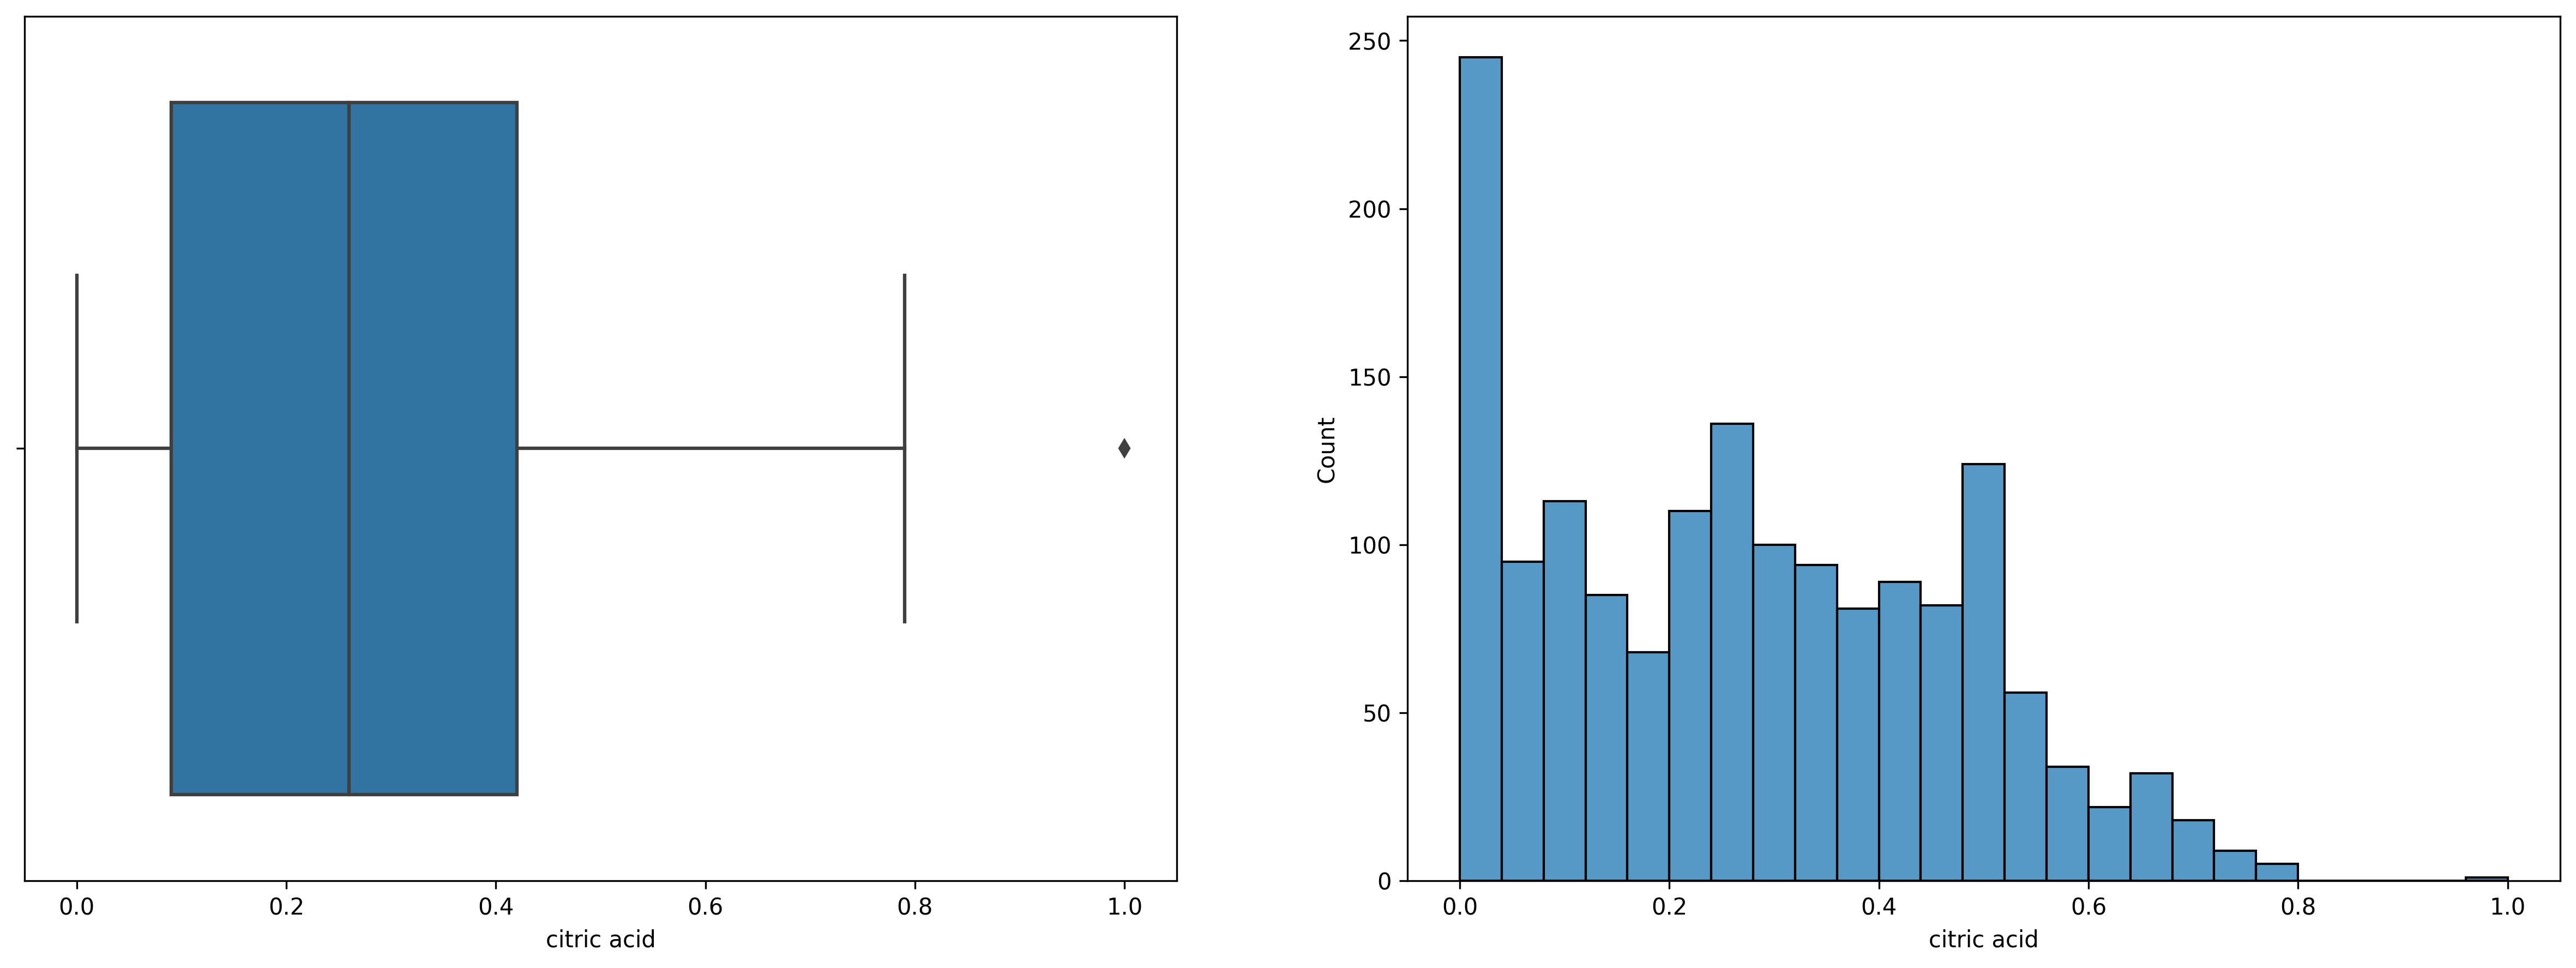

_____________________________________________________________________________________________________________________
				ANALYSIS OF: RESIDUAL SUGAR 

5 point summary:
     residual sugar
min             0.9
25%             1.9
50%             2.2
75%             2.6
max            15.5
---------------------------------
OUTLIERS in RESIDUAL SUGAR via Z score

Outlier limits:
lower limit: -1.6896558340244985 
upper limit: 6.767266840903798

Total outliers: 30
      outliers   Z-score
33        10.7  5.790187
163        7.3  3.377962
164        7.2  3.307015
274        7.0  3.165119
324       11.0  6.003031
325       11.0  6.003031
396        7.9  3.803649
400        7.9  3.803649
480       15.5  9.195681
494        8.3  4.087440
595        7.9  3.803649
649        8.6  4.300284
652        7.5  3.519858
911        9.0  4.584075
917        8.8  4.442179
923        8.8  4.442179
1043       8.9  4.513127
1071       8.1  3.945545
1074       8.1  3.945545
1079       8.3  4.087440
1081       

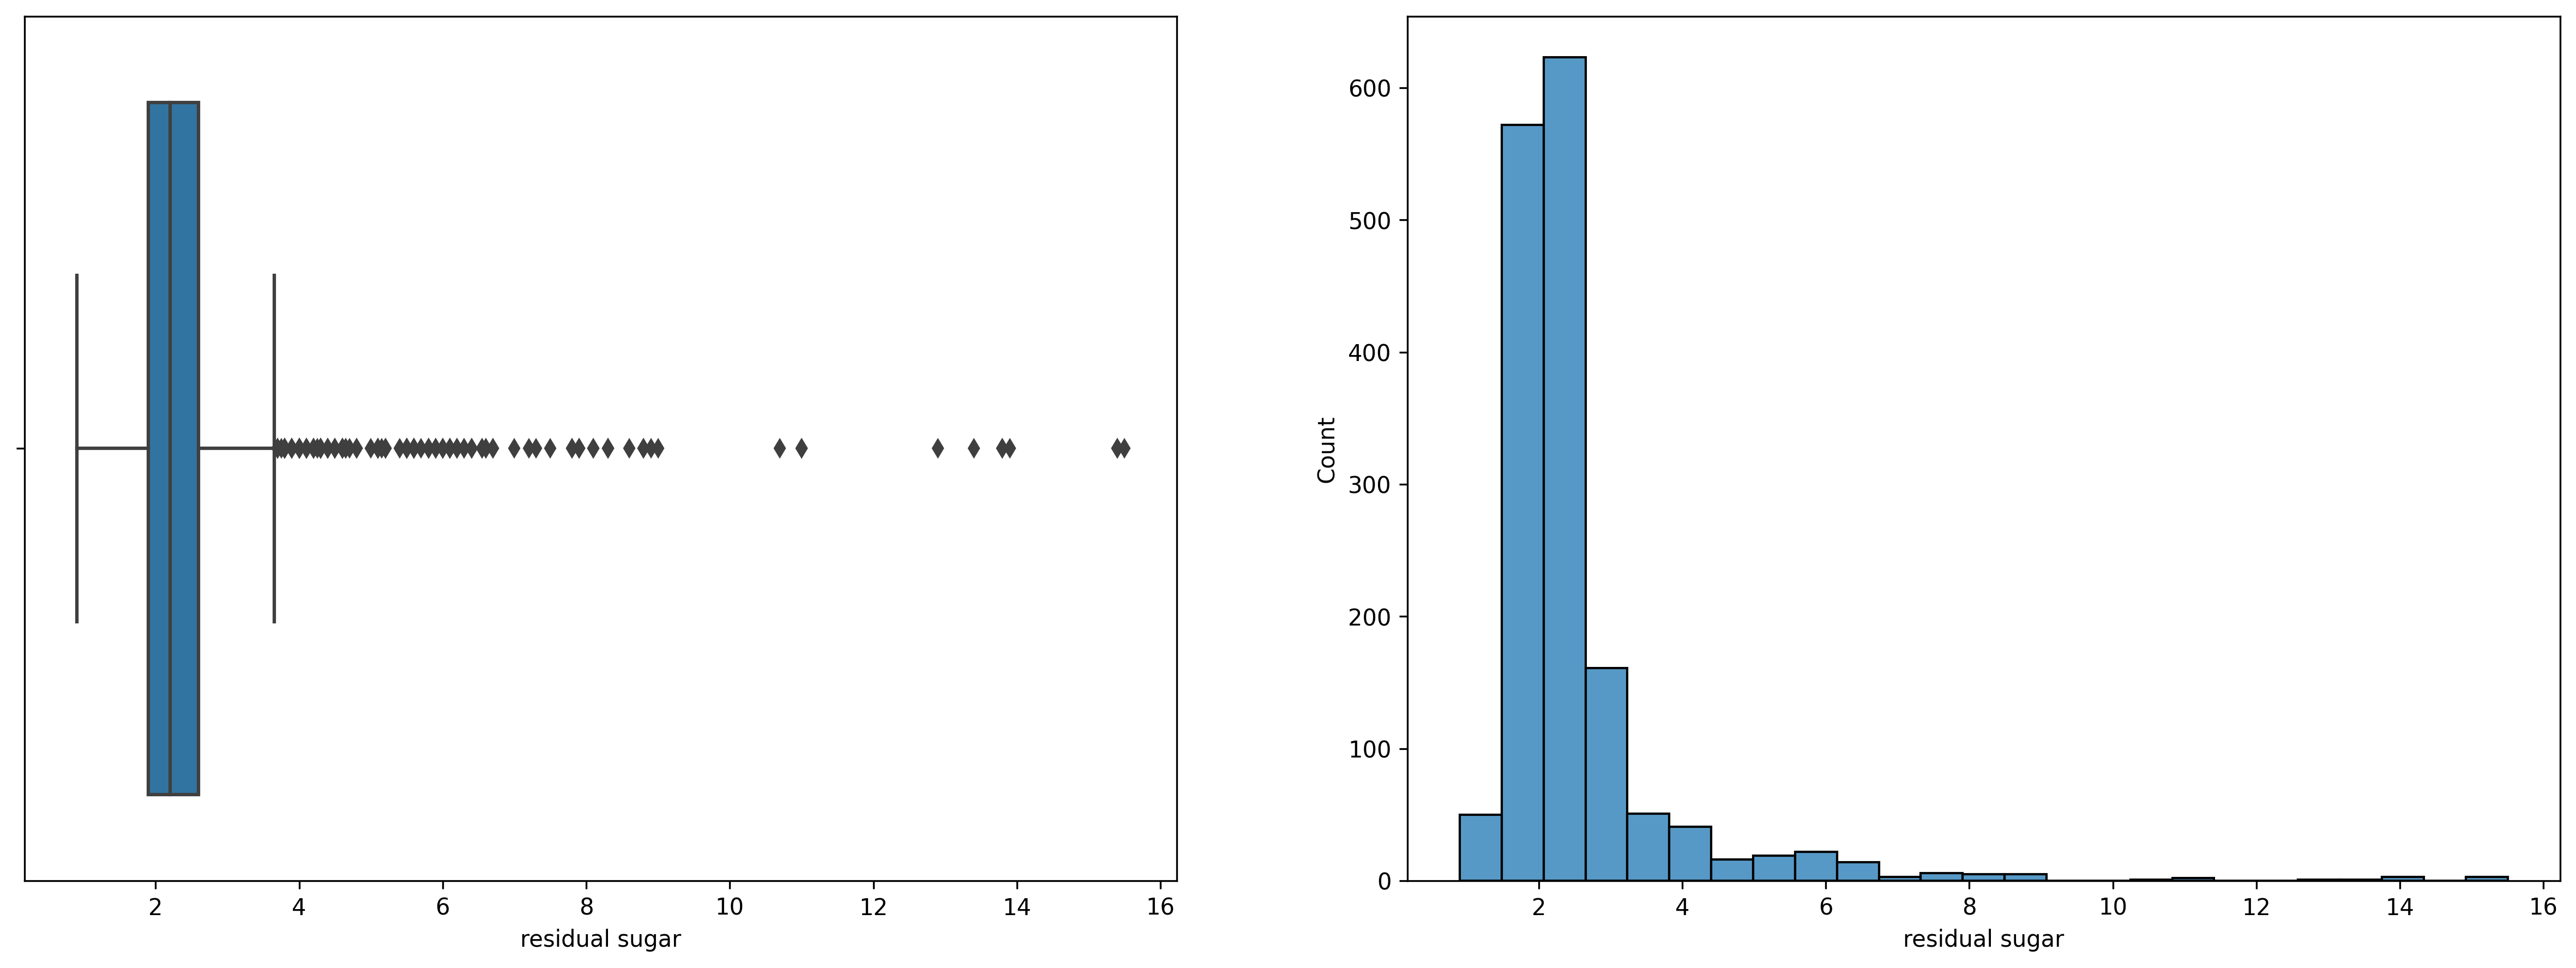

_____________________________________________________________________________________________________________________
				ANALYSIS OF: CHLORIDES 

5 point summary:
     chlorides
min      0.012
25%      0.070
50%      0.079
75%      0.090
max      0.611
---------------------------------
OUTLIERS in CHLORIDES via Z score

Outlier limits:
lower limit: -0.05368520622145434 
upper limit: 0.22861828939843992

Total outliers: 31
      outliers    Z-score
17       0.368   5.962380
19       0.341   5.388530
42       0.332   5.197246
81       0.464   8.002737
83       0.401   6.663753
106      0.467   8.066499
147      0.236   3.156889
151      0.610  11.105781
169      0.360   5.792350
181      0.270   3.879515
226      0.337   5.303515
240      0.263   3.730739
258      0.611  11.127035
281      0.358   5.749843
291      0.343   5.431037
451      0.413   6.918798
568      0.250   3.454441
692      0.422   7.110081
730      0.387   6.366201
754      0.415   6.961305
776      0.243   3.305665
7

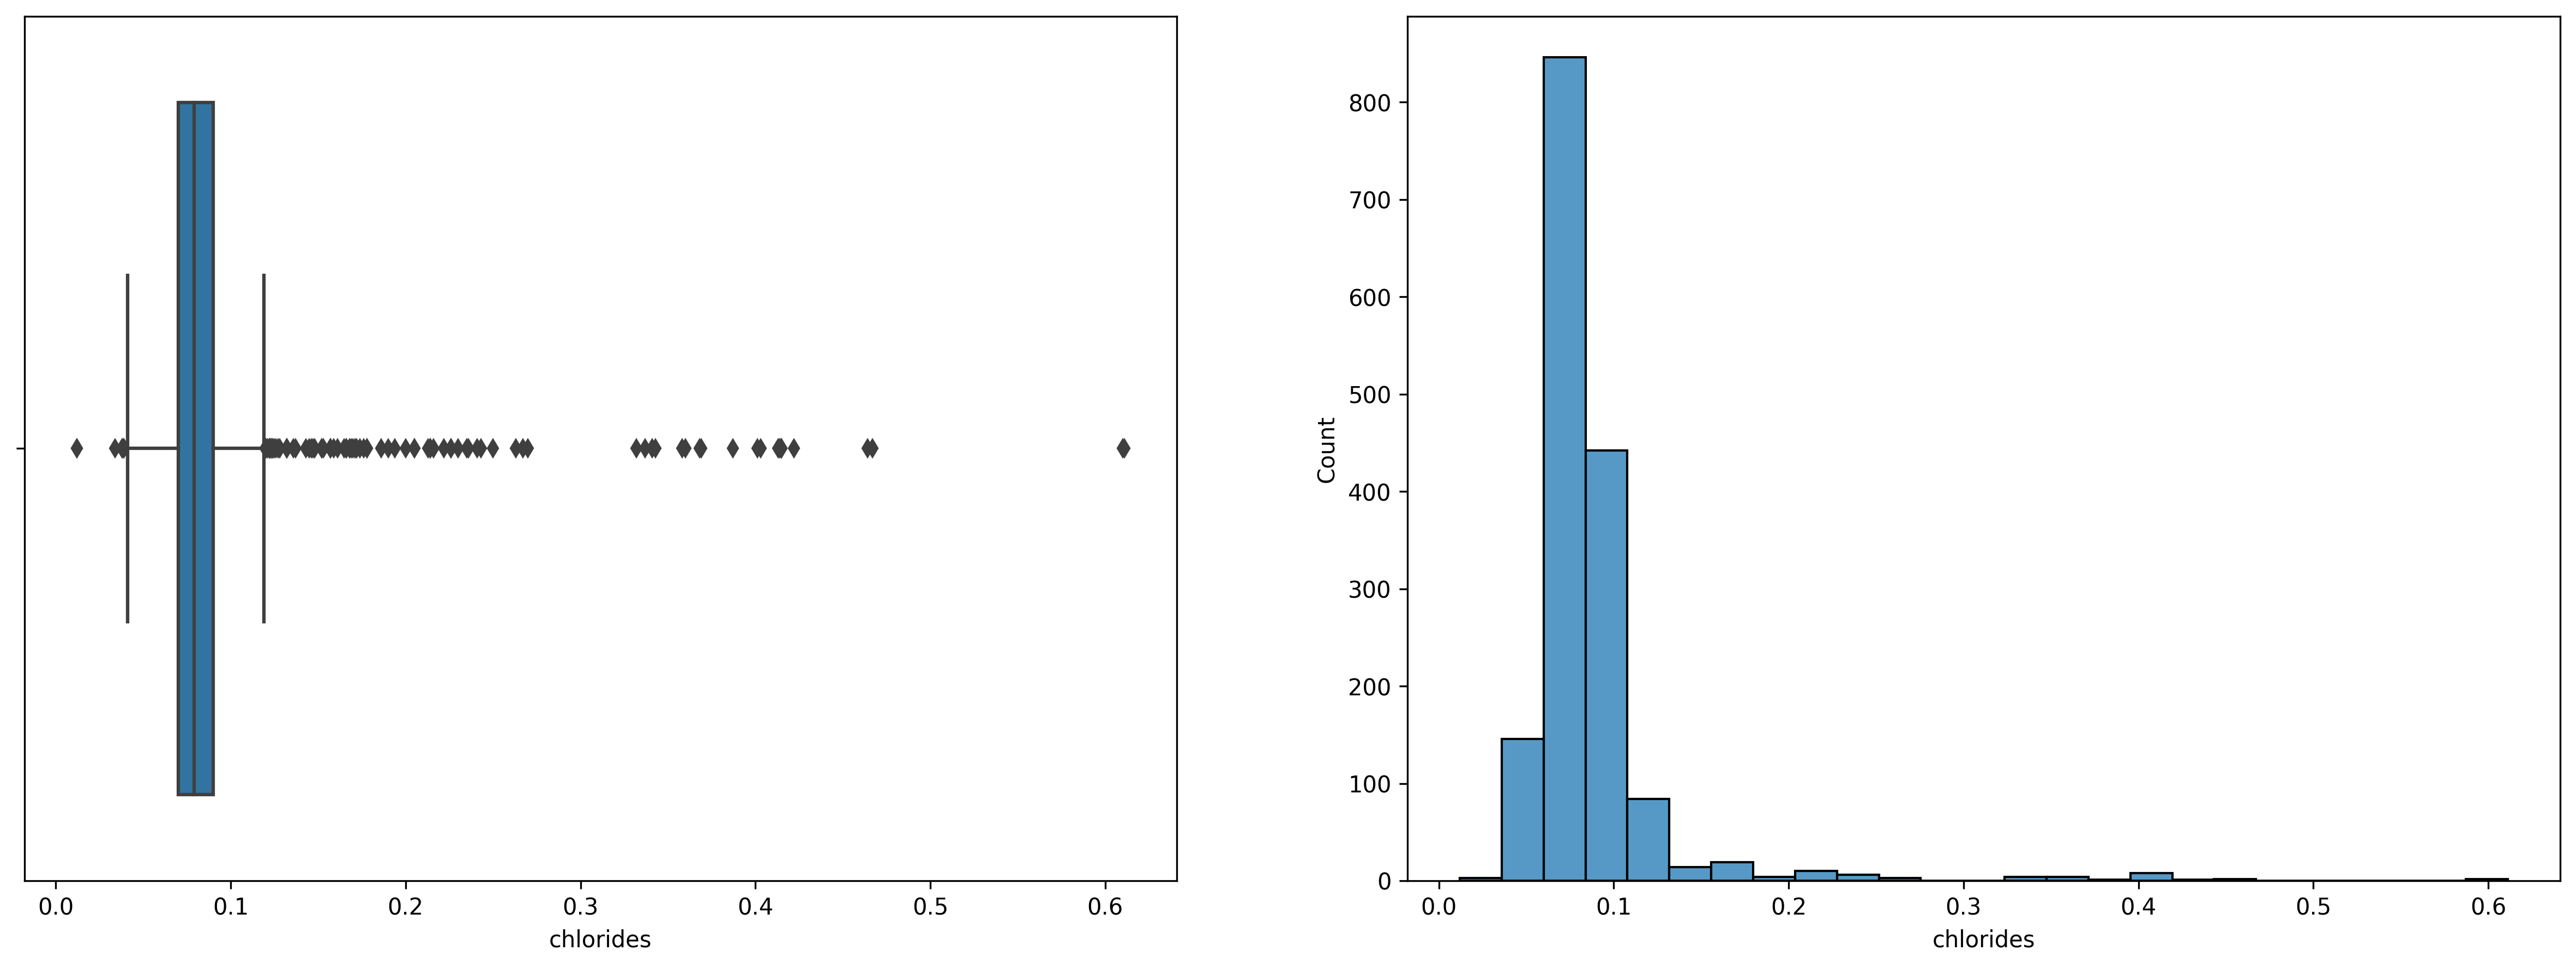

_____________________________________________________________________________________________________________________
				ANALYSIS OF: FREE SULFUR DIOXIDE 

5 point summary:
     free sulfur dioxide
min                  1.0
25%                  7.0
50%                 14.0
75%                 21.0
max                 72.0
---------------------------------
OUTLIERS in FREE SULFUR DIOXIDE via Z score

Outlier limits:
lower limit: -15.49573501865082 
upper limit: 47.2455786709335

Total outliers: 22
      outliers   Z-score
14        52.0  3.454669
15        51.0  3.359038
57        50.0  3.263407
396       68.0  4.984761
400       68.0  4.984761
584       54.0  3.645930
925       53.0  3.550300
926       52.0  3.454669
982       51.0  3.359038
1131      57.0  3.932823
1154      50.0  3.263407
1175      48.0  3.072146
1231      48.0  3.072146
1244      72.0  5.367284
1295      51.0  3.359038
1296      51.0  3.359038
1358      52.0  3.454669
1434      55.0  3.741561
1435      55.0  3.74156

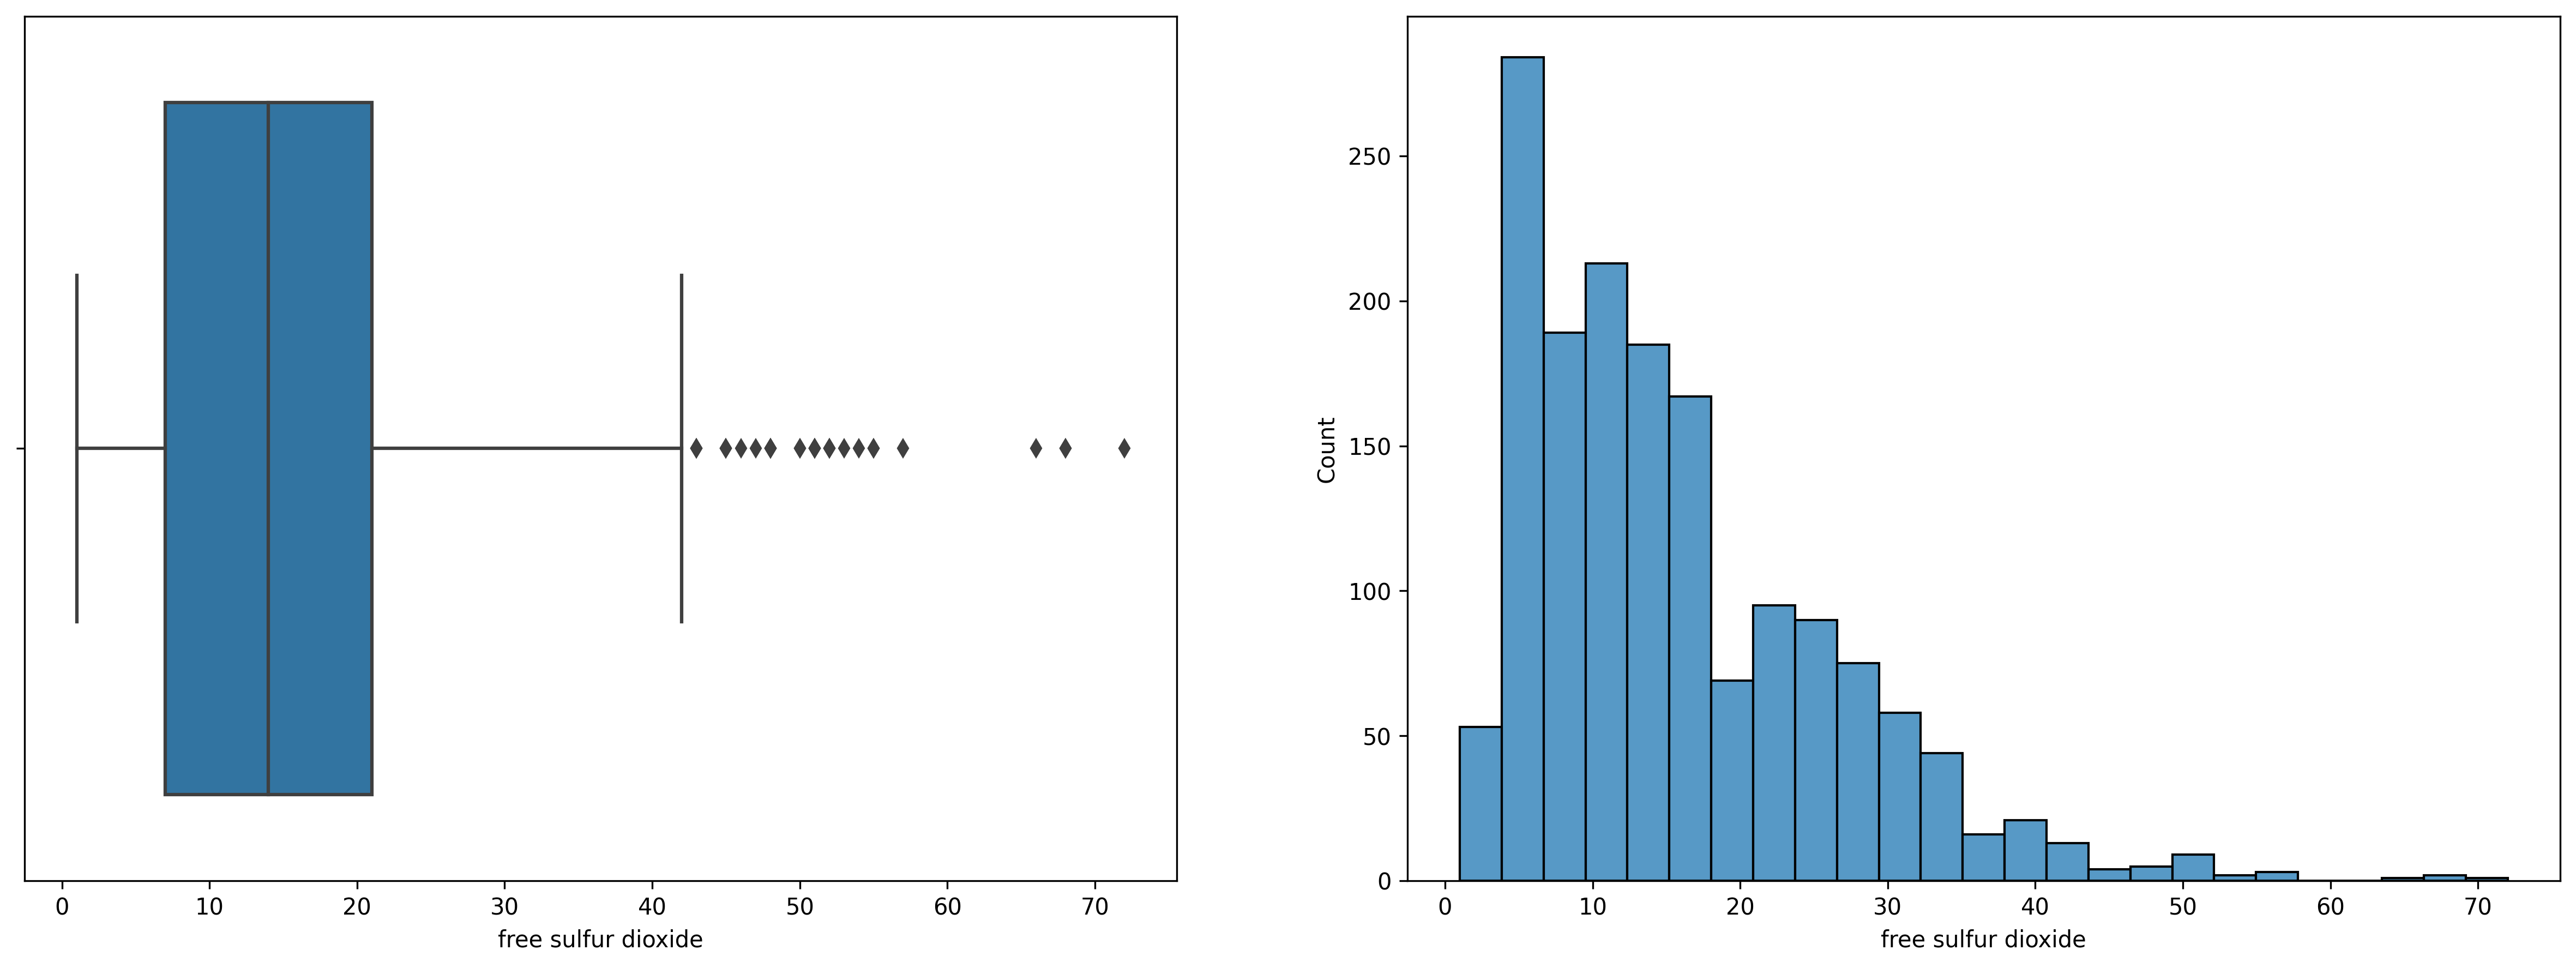

_____________________________________________________________________________________________________________________
				ANALYSIS OF: TOTAL SULFUR DIOXIDE 

5 point summary:
     total sulfur dioxide
min                   6.0
25%                  22.0
50%                  38.0
75%                  62.0
max                 289.0
---------------------------------
OUTLIERS in TOTAL SULFUR DIOXIDE via Z score

Outlier limits:
lower limit: -52.18731758511984 
upper limit: 145.12290232558263

Total outliers: 15
      outliers   Z-score
15       148.0  3.087490
109      153.0  3.239534
354      165.0  3.604442
515      151.0  3.178716
591      149.0  3.117899
636      147.0  3.057081
649      148.0  3.087490
651      155.0  3.300352
672      151.0  3.178716
684      152.0  3.209125
1079     278.0  7.040655
1081     289.0  7.375154
1244     160.0  3.452397
1493     147.0  3.057081
1496     147.0  3.057081
---------------------------------
OUTLIERS in TOTAL SULFUR DIOXIDE via IQR

Outlier limi

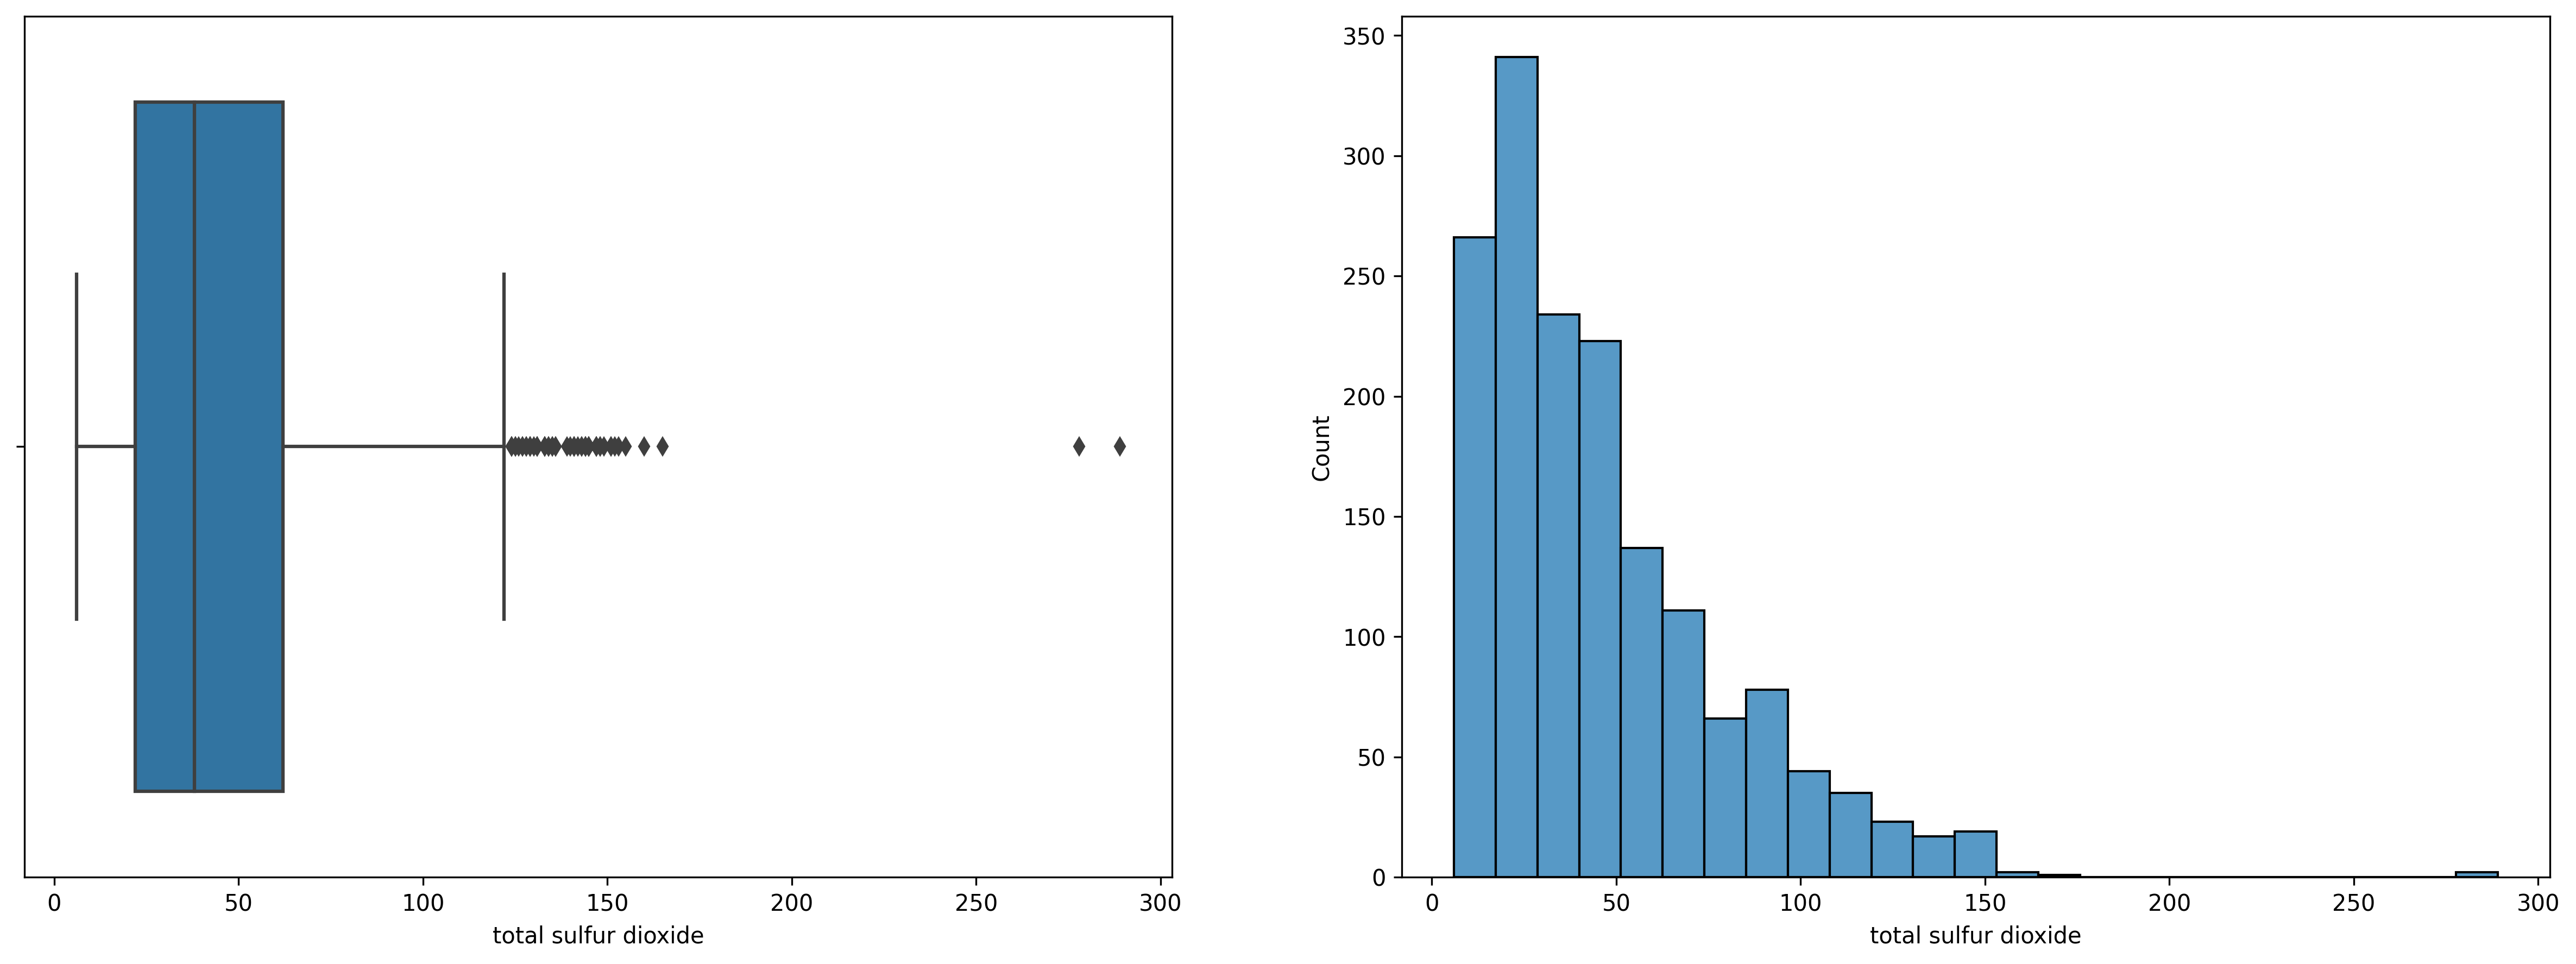

_____________________________________________________________________________________________________________________
				ANALYSIS OF: DENSITY 

5 point summary:
      density
min  0.990070
25%  0.995600
50%  0.996750
75%  0.997835
max  1.003690
---------------------------------
OUTLIERS in DENSITY via Z score

Outlier limits:
lower limit: 0.991086448071987 
upper limit: 1.0024069102769813

Total outliers: 18
      outliers   Z-score
442    1.00320  3.420348
480    1.00260  3.102340
554    1.00315  3.393848
555    1.00315  3.393848
557    1.00315  3.393848
608    1.00260  3.102340
836    0.99064 -3.236624
837    0.99064 -3.236624
889    1.00289  3.256044
1017   0.99007 -3.538731
1018   0.99007 -3.538731
1114   0.99020 -3.469830
1269   0.99080 -3.151821
1270   0.99084 -3.130621
1434   1.00369  3.680055
1435   1.00369  3.680055
1474   1.00242  3.006938
1476   1.00242  3.006938
---------------------------------
OUTLIERS in DENSITY via IQR

Outlier limits:
lower limit: 0.9922475000000001 


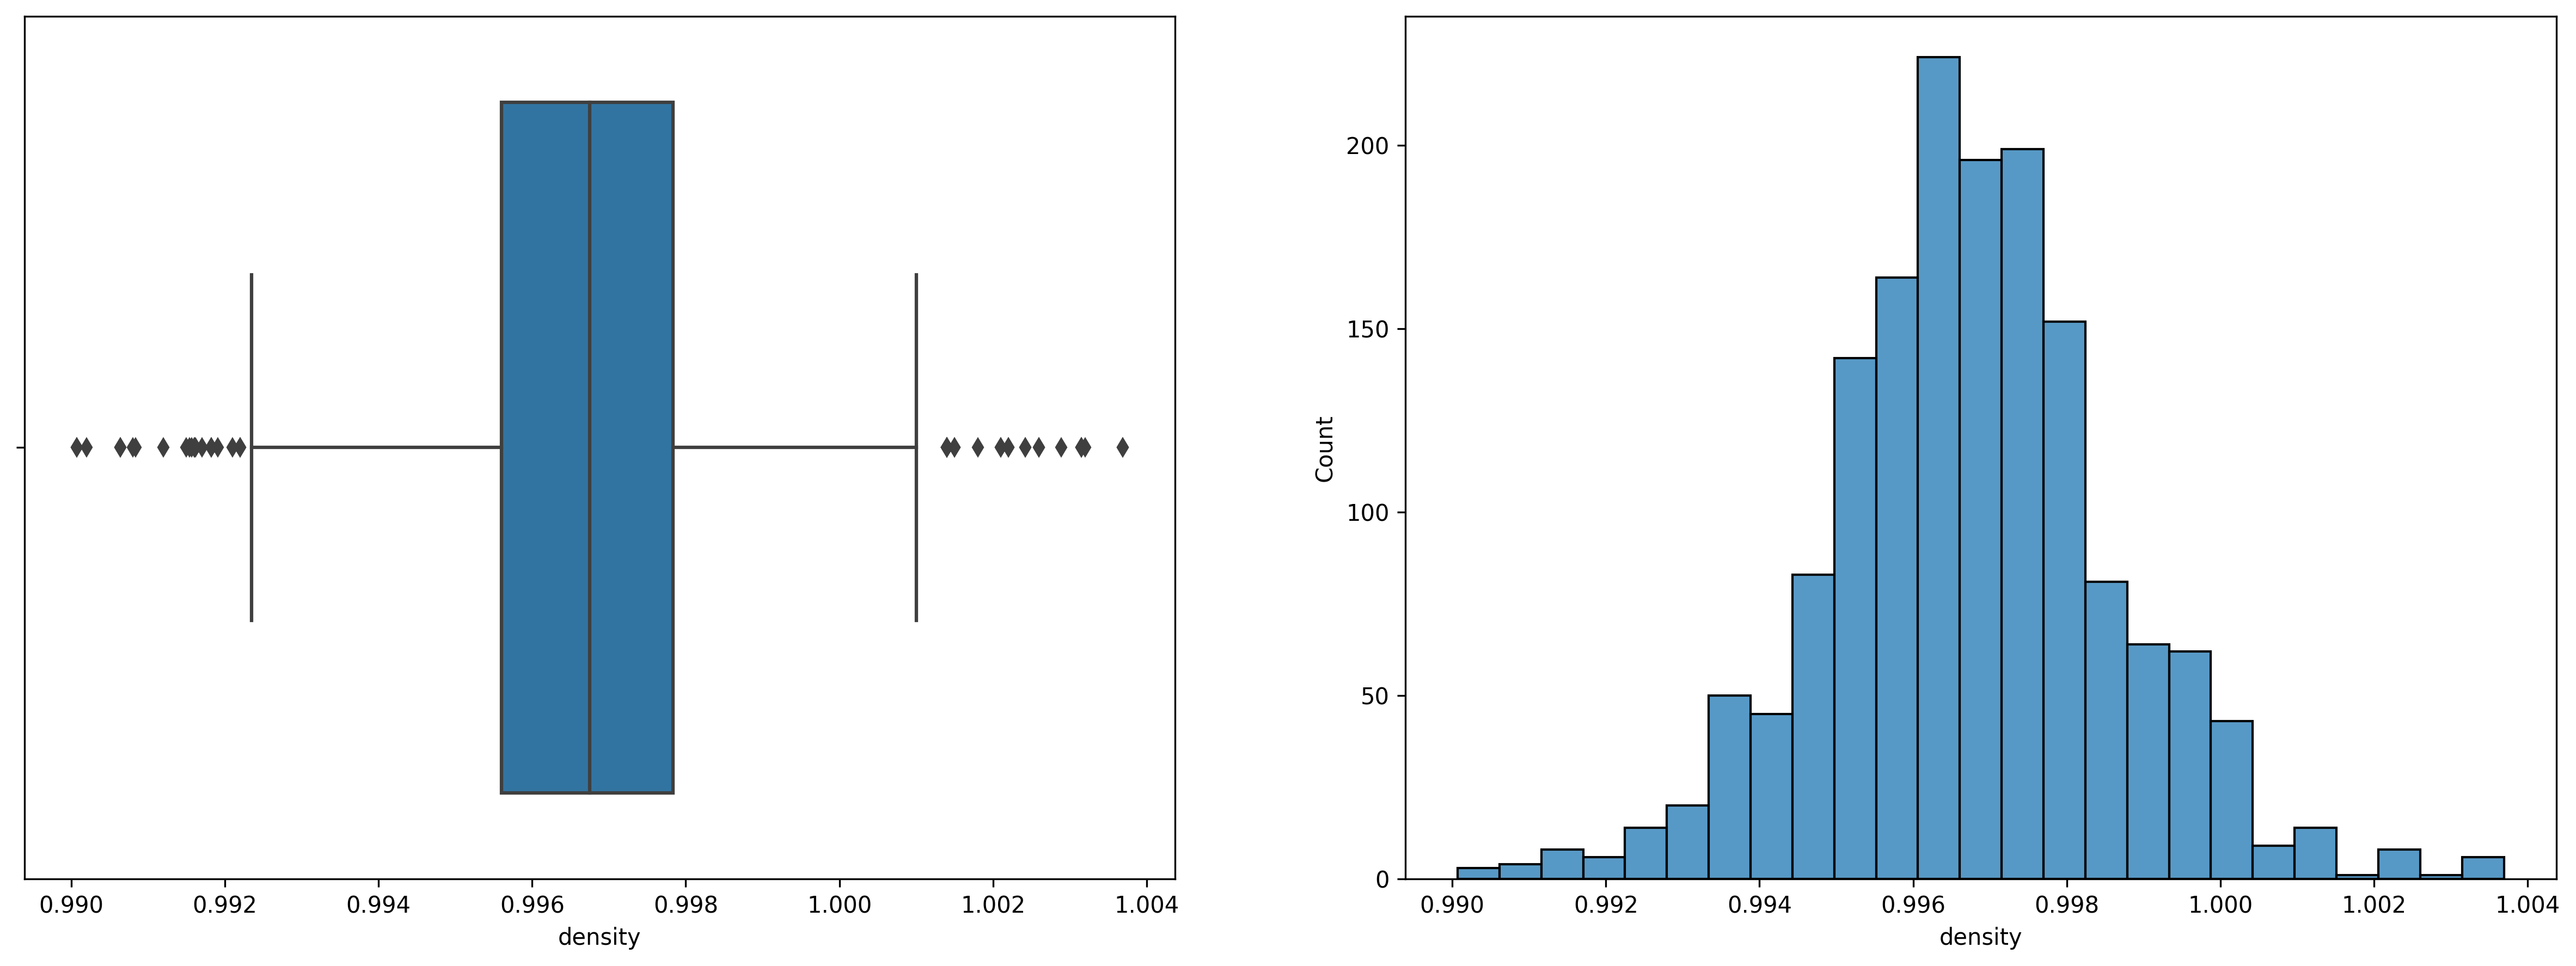

_____________________________________________________________________________________________________________________
				ANALYSIS OF: PH 

5 point summary:
       pH
min  2.74
25%  3.21
50%  3.31
75%  3.40
max  4.01
---------------------------------
OUTLIERS in PH via Z score

Outlier limits:
lower limit: 2.848098651515537 
upper limit: 3.7741277399791464

Total outliers: 8
      outliers   Z-score
45        3.90  3.815561
95        3.85  3.491597
151       2.74 -3.700401
695       3.90  3.815561
1111      3.78  3.038048
1300      3.78  3.038048
1316      4.01  4.528282
1321      4.01  4.528282
---------------------------------
OUTLIERS in PH via IQR

Outlier limits:
lower limit: 2.925 
upper limit: 3.6849999999999996

Total outliers: 35
      outliers
45        3.90
94        3.75
95        3.85
151       2.74
268       3.69
276       3.69
440       2.88
544       2.86
553       3.74
554       2.92
555       2.92
557       2.92
588       3.72
614       2.87
650       2.89
656       2

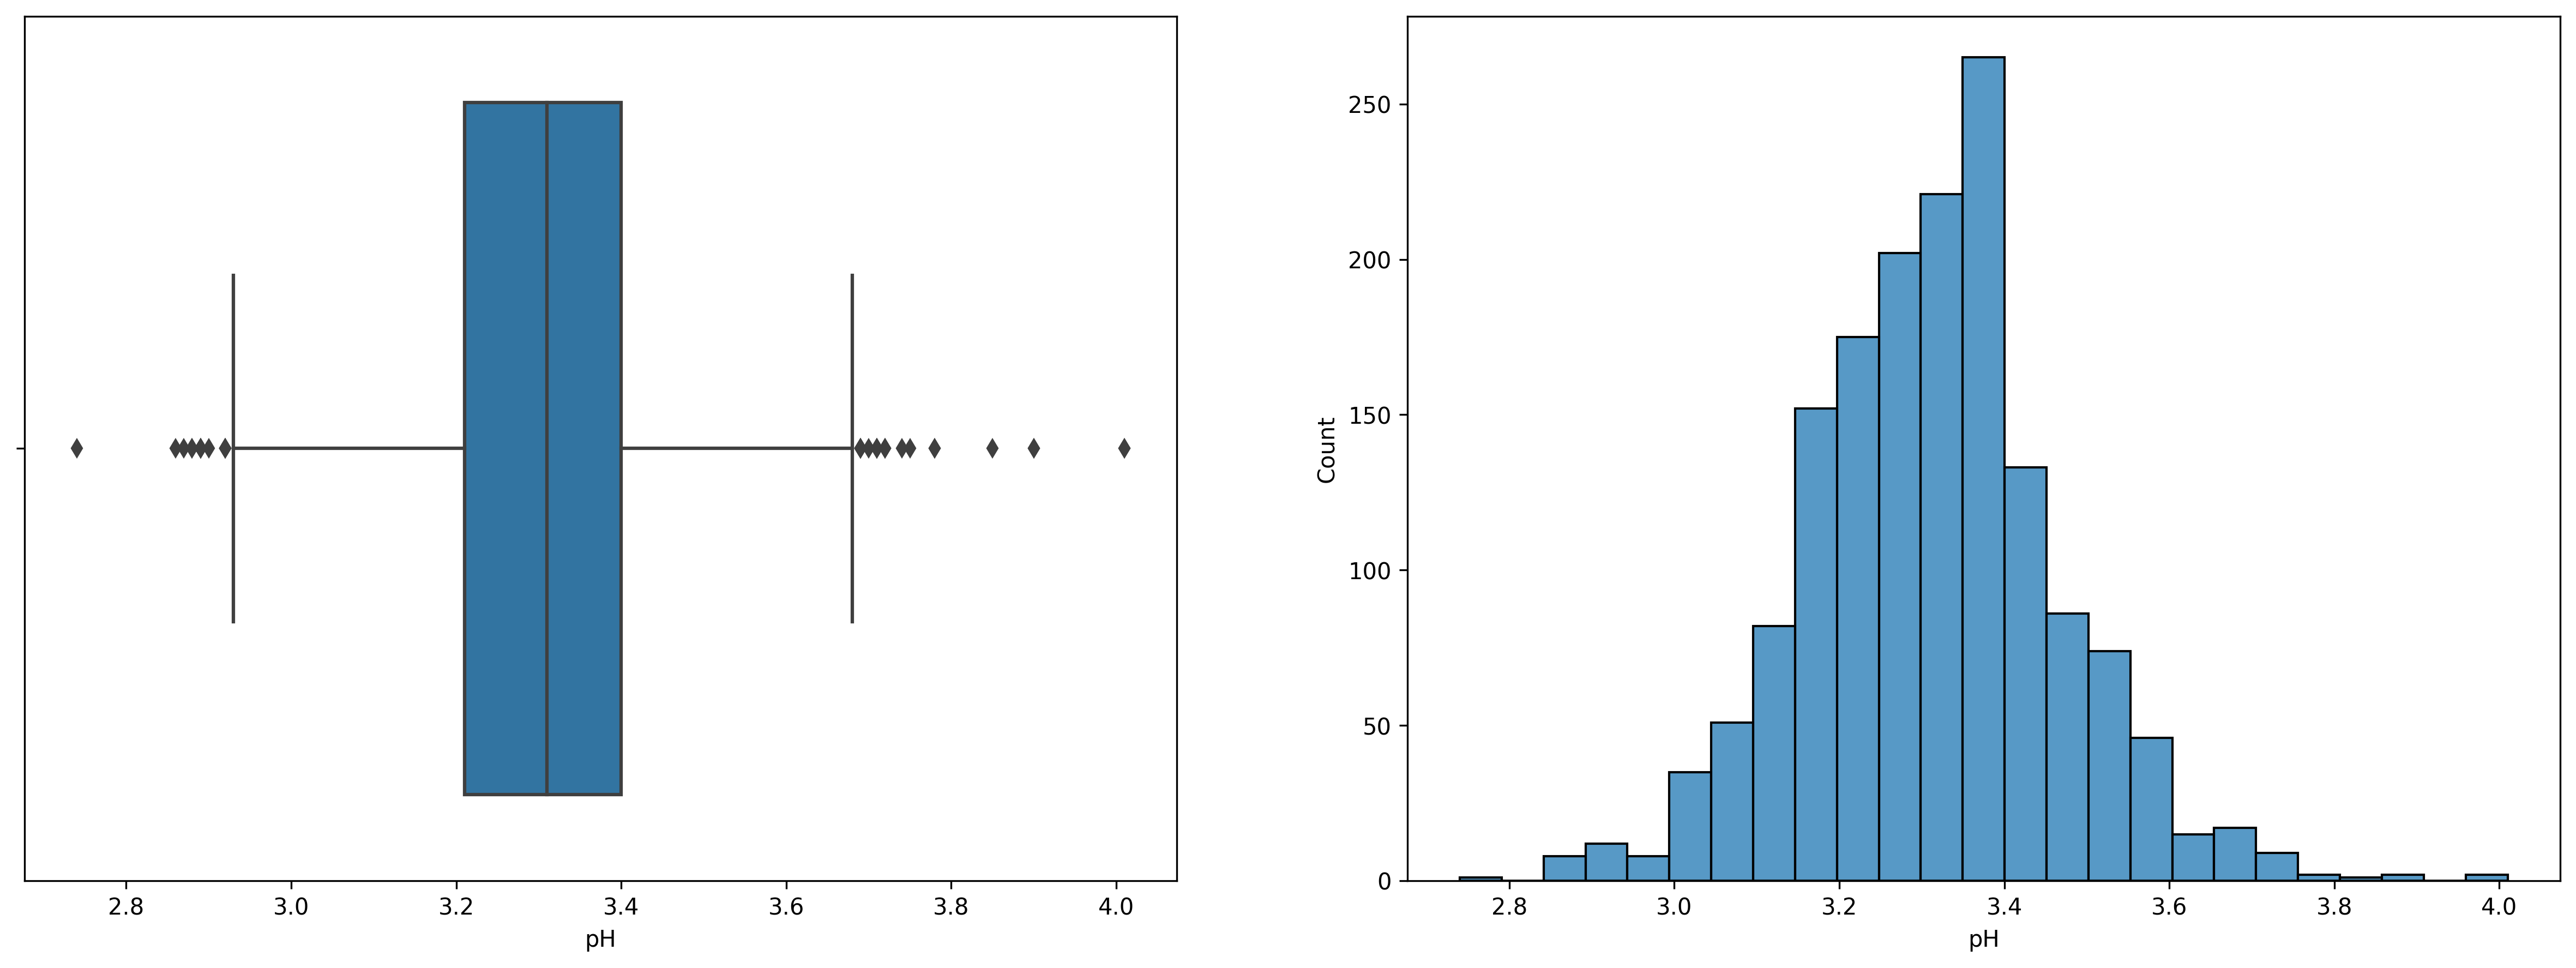

_____________________________________________________________________________________________________________________
				ANALYSIS OF: SULPHATES 

5 point summary:
     sulphates
min       0.33
25%       0.55
50%       0.62
75%       0.73
max       2.00
---------------------------------
OUTLIERS in SULPHATES via Z score

Outlier limits:
lower limit: 0.14978694130150527 
upper limit: 1.1665107447522782

Total outliers: 27
      outliers   Z-score
13        1.56  5.322101
17        1.28  3.669735
43        1.20  3.197630
81        1.28  3.669735
86        1.95  7.623611
88        1.22  3.315657
91        1.95  7.623611
92        1.98  7.800650
106       1.31  3.846774
151       2.00  7.918677
169       1.59  5.499140
226       1.61  5.617167
258       1.26  3.551709
339       1.36  4.141840
340       1.18  3.079604
614       1.36  4.141840
639       1.36  4.141840
692       1.17  3.020591
723       1.62  5.676180
795       1.18  3.079604
1051      1.34  4.023813
1288      1.17  3.020591


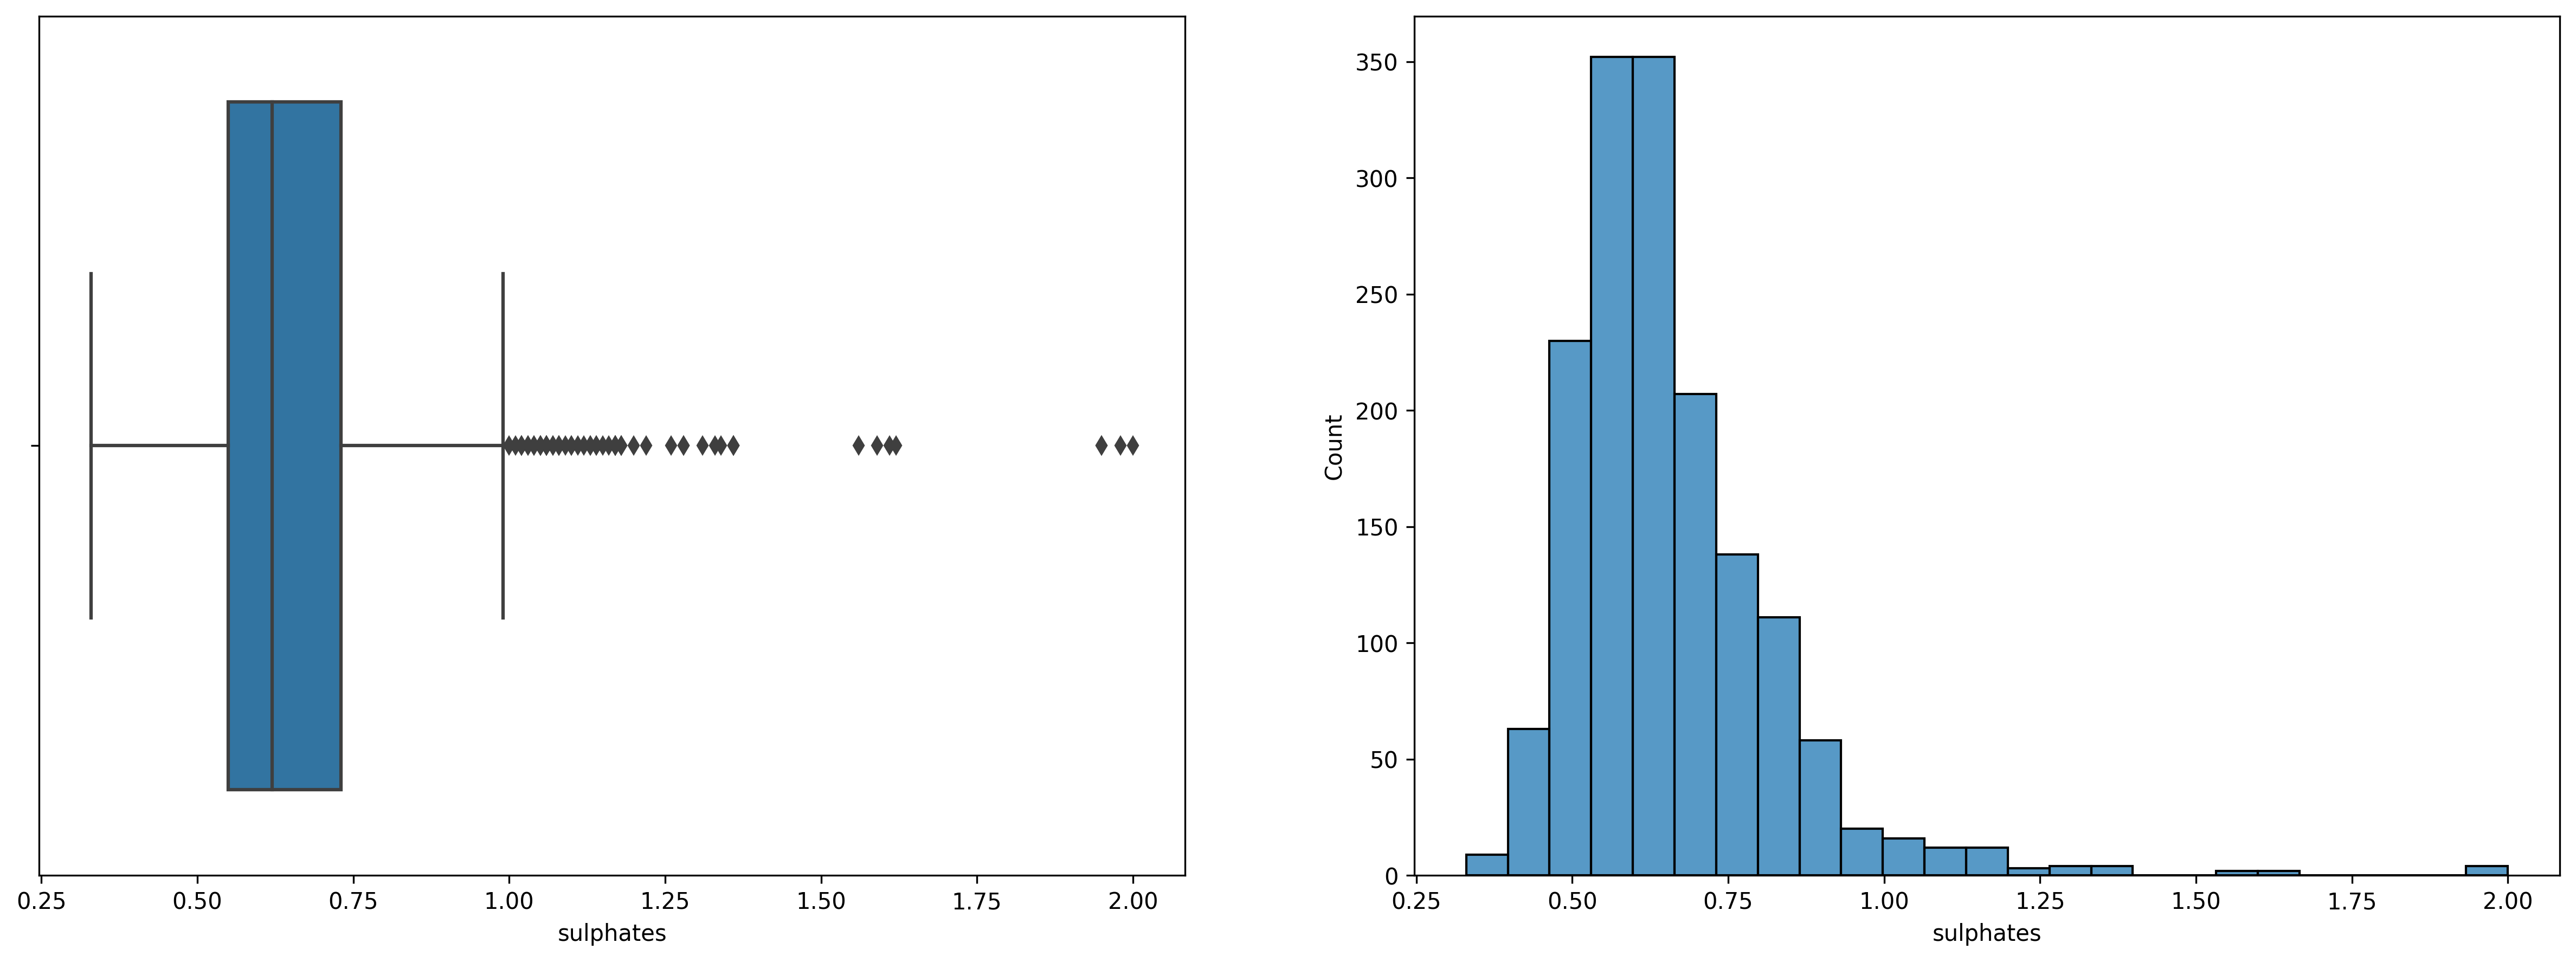

_____________________________________________________________________________________________________________________
				ANALYSIS OF: ALCOHOL 

5 point summary:
     alcohol
min      8.4
25%      9.5
50%     10.2
75%     11.1
max     14.9
---------------------------------
OUTLIERS in ALCOHOL via Z score

Outlier limits:
lower limit: 7.226980213415284 
upper limit: 13.618986015477773

Total outliers: 8
      outliers   Z-score
142       14.0  3.357647
144       14.0  3.357647
467       14.0  3.357647
588       14.0  3.357647
652       14.9  4.202453
821       14.0  3.357647
1269      14.0  3.357647
1270      14.0  3.357647
---------------------------------
OUTLIERS in ALCOHOL via IQR

Outlier limits:
lower limit: 7.1000000000000005 
upper limit: 13.5

Total outliers: 13
       outliers
142   14.000000
144   14.000000
467   14.000000
588   14.000000
652   14.900000
821   14.000000
1114  13.600000
1132  13.600000
1228  13.600000
1269  14.000000
1270  14.000000
1475  13.566667
1477  13.60

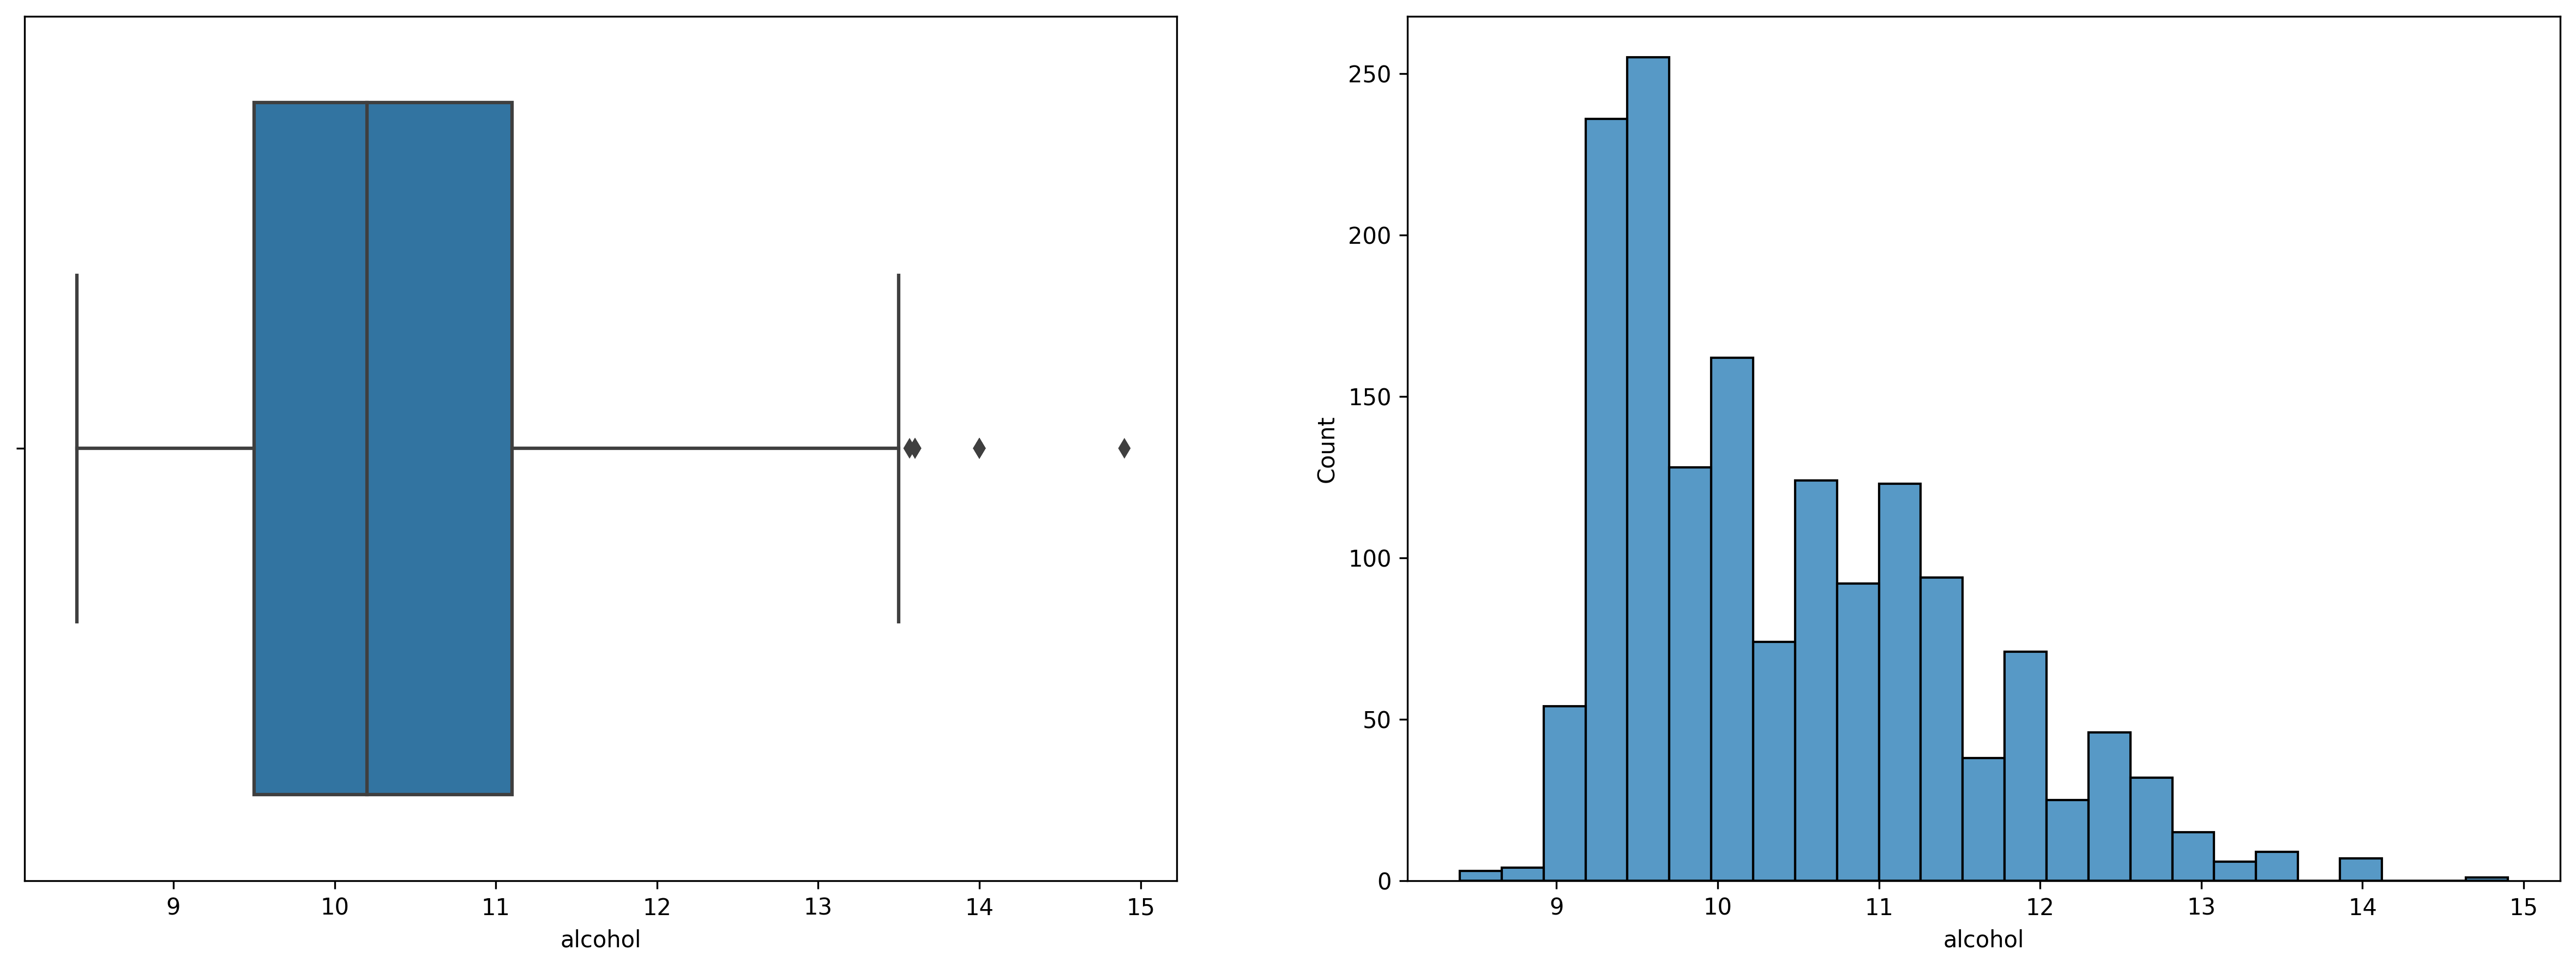

_____________________________________________________________________________________________________________________
				ANALYSIS OF: QUALITY 

5 point summary:
     quality
min      3.0
25%      5.0
50%      6.0
75%      6.0
max      8.0
---------------------------------
OUTLIERS in QUALITY via Z score

Outlier limits:
lower limit: 3.214071883179441 
upper limit: 8.057973144963148

Total outliers: 10
      outliers   Z-score
459          3 -3.265165
517          3 -3.265165
690          3 -3.265165
832          3 -3.265165
899          3 -3.265165
1299         3 -3.265165
1374         3 -3.265165
1469         3 -3.265165
1478         3 -3.265165
1505         3 -3.265165
---------------------------------
OUTLIERS in QUALITY via IQR

Outlier limits:
lower limit: 3.5 
upper limit: 7.5

Total outliers: 28
      outliers
267          8
278          8
390          8
440          8
455          8
459          3
481          8
495          8
498          8
517          3
588          8
690  

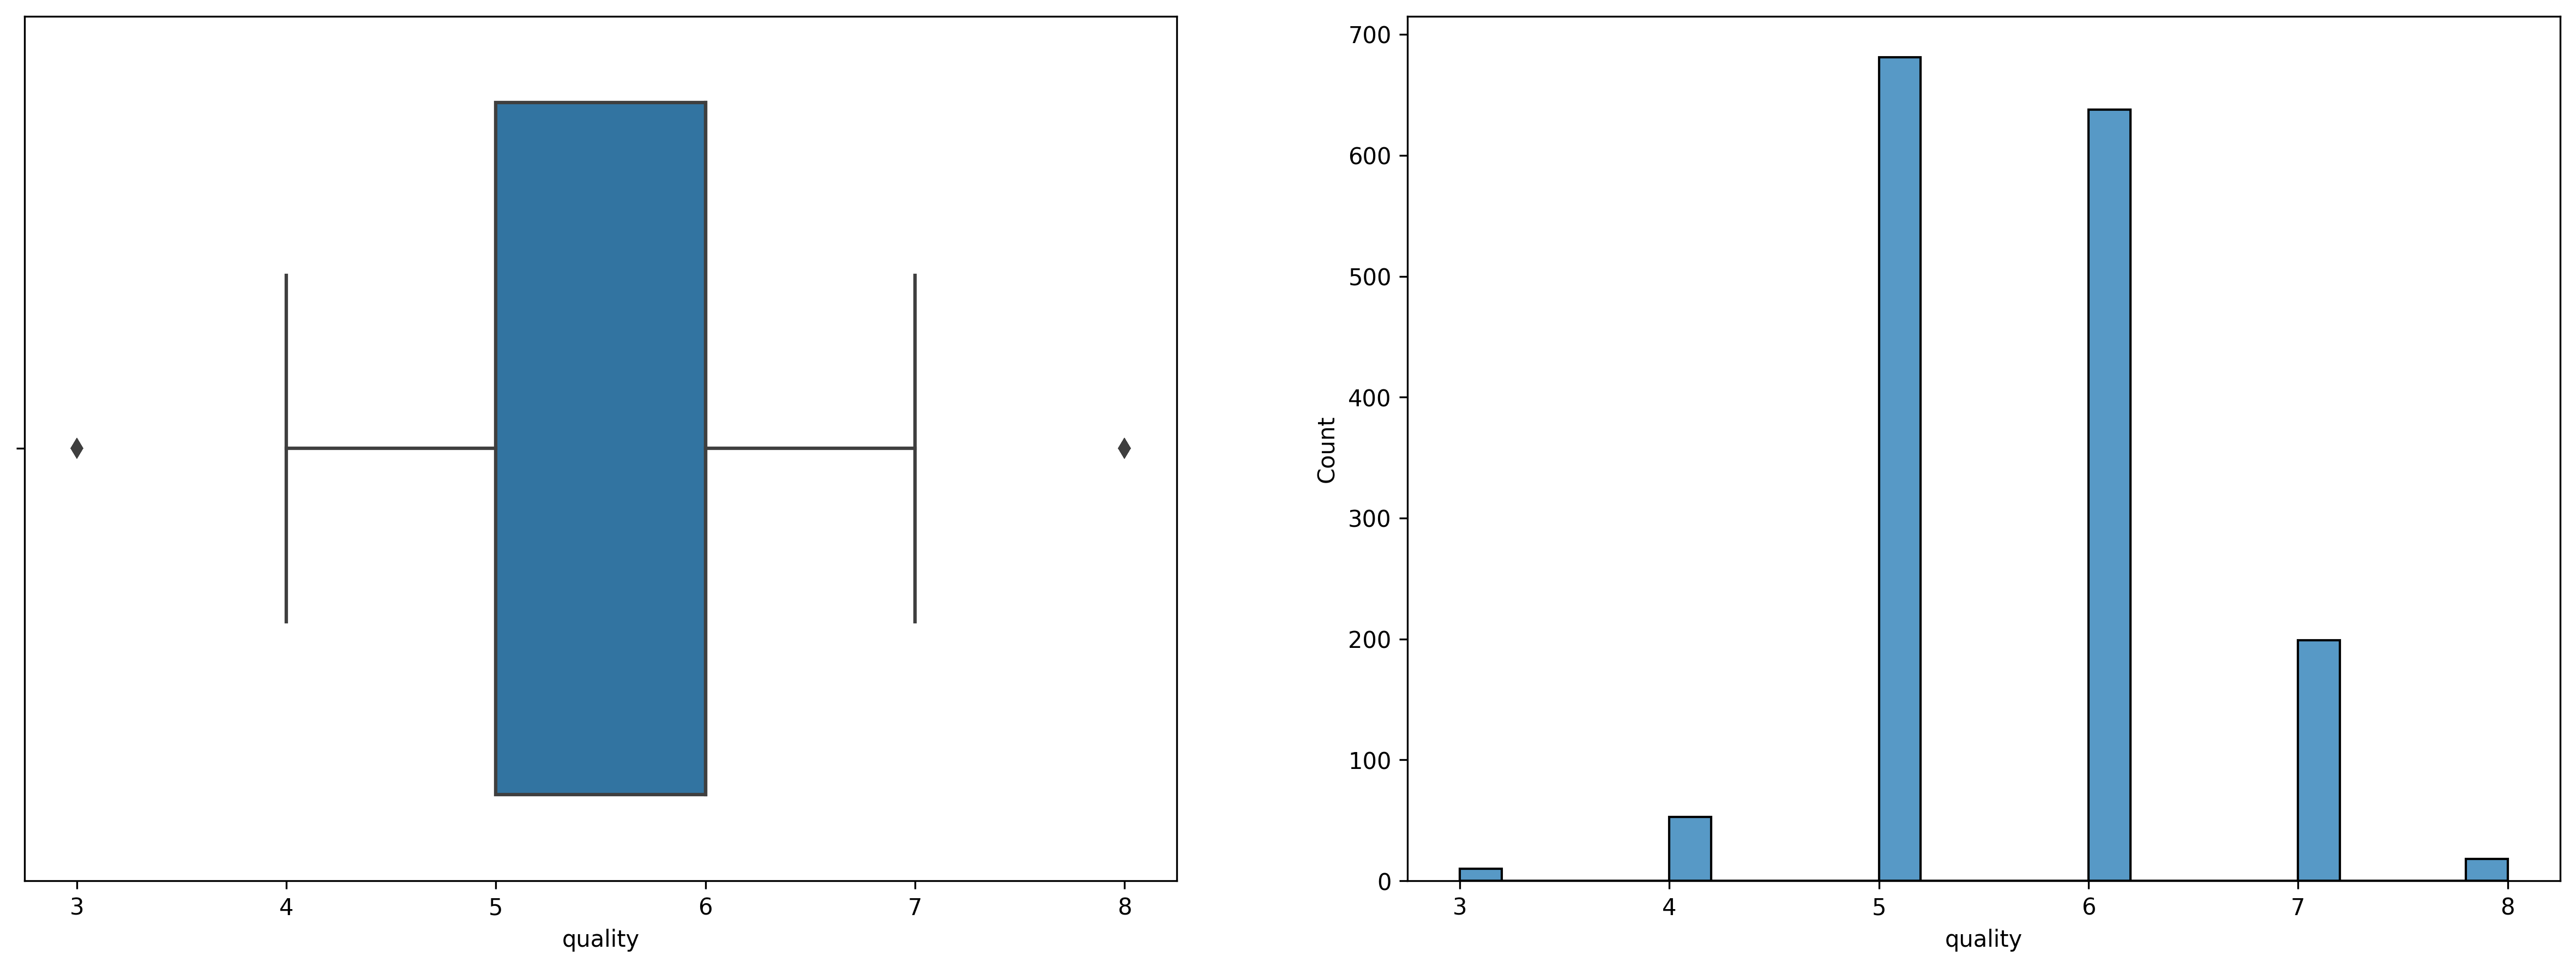

_____________________________________________________________________________________________________________________


In [14]:
for col in wine.columns:
    analysis_quant(wine[col])

## Outlier handling

In [15]:
handling_list=['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide']

#### outlier compression

Compressed the following outliers:
      outliers   Z-score
243      15.0  3.838072
244      15.0  3.838072
347      13.8  3.148635
374      14.0  3.263541
381      13.7  3.091182
391      13.7  3.091182
442      15.6  4.182790
544      14.3  3.435900
554      15.5  4.125337
555      15.5  4.125337
557      15.6  4.182790
652      15.9  4.355149
Compressed the following outliers:
       outliers   Z-score
38       1.130  3.364062
120      1.070  3.028873
126      1.330  4.481357
127      1.330  4.481357
199      1.090  3.140603
672      1.240  3.978574
690      1.185  3.671318
724      1.115  3.280264
1299     1.580  5.877976
1312     1.180  3.643385
Compressed the following outliers:
      outliers   Z-score
151       1.0  3.743574
Compressed the following outliers:
       outliers   Z-score
33        10.7  5.790187
163        7.3  3.377962
164        7.2  3.307015
274        7.0  3.165119
324       11.0  6.003031
325       11.0  6.003031
396        7.9  3.803649
400        7.9  3.803

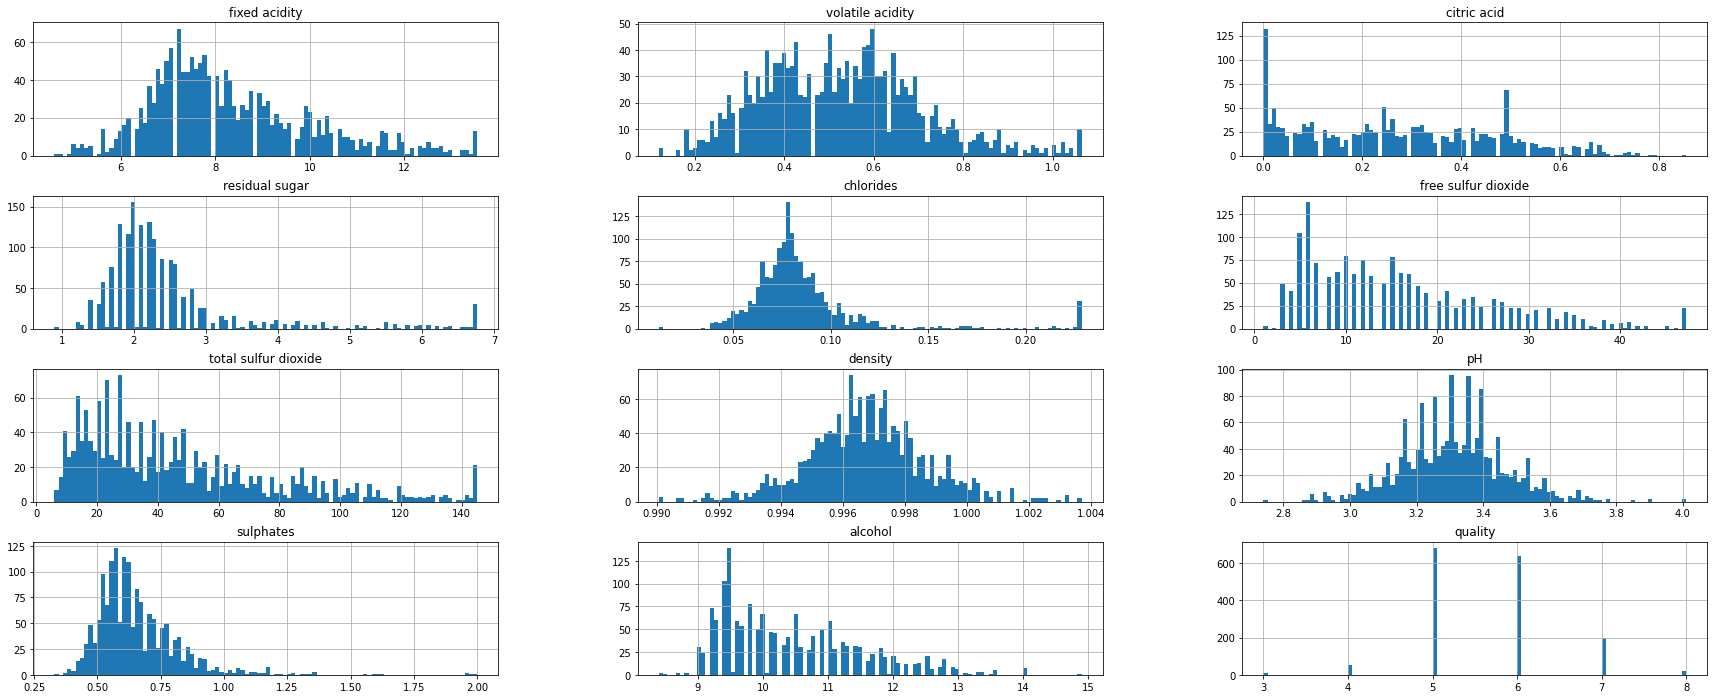

In [16]:
for column in handling_list:
    compress_outliers(wine,column,using='Z')
    
wine.hist(figsize=(30,12),bins=100)
plt.show()

#### outlier removal

In [17]:
# for column in handling_list:
#     remove_outliers(wine,column,using='Z')
    
# wine.hist(figsize=(30,12),bins=100)
# plt.show()

## Correlation

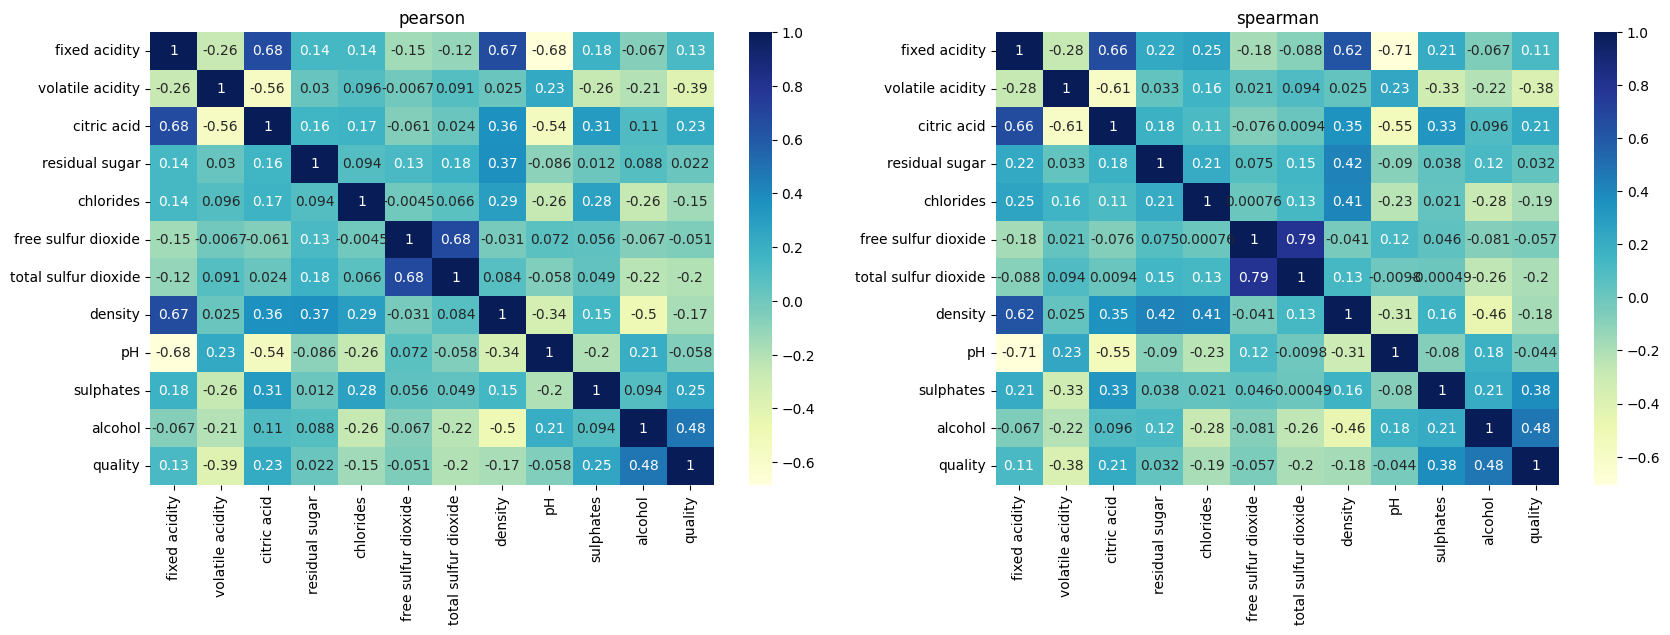

In [18]:
fig,ax=plt.subplots(1,2,figsize=(20,6), dpi=100)
sns.heatmap(wine.corr(), annot=True, cmap='YlGnBu',ax=ax[0])
ax[0].set_title('pearson')
sns.heatmap(wine.corr(method='spearman'), annot=True, cmap='YlGnBu',ax=ax[1])
ax[1].set_title('spearman')
plt.show()

## Separating features and label

In [19]:
X=wine.drop('quality',axis=1)
y=wine.quality

## models and params

In [20]:
'''LogReg'''
model_lr=LogisticRegression(n_jobs=-1)

params_lr={'logisticregression__C':[0.0001,0.001,0.01,0.1,1,10], 
           'logisticregression__solver':['lbfgs','sag','saga','newton-cg'],
           'logisticregression__penalty':['none','l2','l1','elasticnet'], 
           'logisticregression__l1_ratio':[None,0,1] 
          }

In [21]:
'''DTree'''
model_dt=DecisionTreeClassifier()

params_dt={'decisiontreeclassifier__criterion':["gini","entropy","log_loss"], 
           'decisiontreeclassifier__max_depth':[None]+list(range(1,52,5)),
           'decisiontreeclassifier__min_samples_split':range(2,33,5), 
           'decisiontreeclassifier__min_samples_leaf':range(1,32,5), 
           'decisiontreeclassifier__max_features':np.arange(0.1,0.91,0.1)
          }

In [22]:
'''RForest'''
model_rf=RandomForestClassifier(n_jobs=-1)

params_rf={'randomforestclassifier__n_estimators':range(50,551,100), 
           'randomforestclassifier__criterion':["gini", "entropy", "log_loss"], 
           'randomforestclassifier__max_depth':[None]+list(range(1,52,5)), 
           'randomforestclassifier__min_samples_split':range(2,33,5), 
           'randomforestclassifier__min_samples_leaf':range(1,32,5), 
           'randomforestclassifier__max_features':np.arange(0.1,0.91,0.1)
          }

In [23]:
'''ADAboost'''
model_ada=AdaBoostClassifier() 

model_dt_opt=DecisionTreeClassifier(max_depth=25, max_features=0.5, min_samples_leaf=15, min_samples_split=15)
model_rf_opt=RandomForestClassifier(n_jobs=-1, max_depth=25, max_features=0.5, min_samples_leaf=15, min_samples_split=15)

params_ada={'adaboostclassifier__base_estimator':[None,model_dt_opt,model_rf_opt ], 
            'adaboostclassifier__n_estimators':range(50,1051,200), 
            'adaboostclassifier__learning_rate':[0.0001,0.001,0.01,0.1,1,10]
            }

In [24]:
'''GradBoost'''
model_gb=GradientBoostingClassifier()

params_gb={'gradientboostingclassifier__learning_rate':[0.0001,0.001,0.01,0.1,1,10],
           'gradientboostingclassifier__subsample':np.arange(0.1,1,0.2),
           'gradientboostingclassifier__criterion':['friedman_mse','squared_error'],
           'gradientboostingclassifier__max_depth':range(1,52,5),
           'gradientboostingclassifier__max_features':np.arange(0.1,0.91,0.1),
          }

In [25]:
'''XGB'''
model_xgb=XGBClassifier(n_jobs=-1, tree_method='gpu_hist')  

params_xgb={'xgbclassifier__n_estimators':range(100,1001,100),
            'xgbclassifier__max_depth':range(1,52,5),
            'xgbclassifier__reg_lambda':[0.0001,0.001,0.01,0.1,1,10,50,100],
            'xgbclassifier__learning_rate':[0.0001,0.001,0.01,0.1,1,10],
            'xgbclassifier__booster':['gbtree','gblinear'],
           }

In [26]:
'''SVC'''
model_svc=SVC()    

params_svc={'svc__C':[0.0001,0.001,0.01,0.1,1,10,50,100,500],
            'svc__kernel':['linear','poly','rbf','sigmoid'],
            'svc__degree':range(2,15,3),
            'svc__gamma':[0.0001,0.001,0.01,0.1,1,10,100]
           }

In [27]:
'''KNC'''
model_knc=KNeighborsClassifier(n_jobs=-1)

params_knc={'kneighborsclassifier__n_neighbors':range(10,101,10),
            'kneighborsclassifier__weights':['uniform','distance'],
            'kneighborsclassifier__algorithm':['auto','ball_tree','kd_tree','brute'],
            'kneighborsclassifier__p':[1,2],
            'kneighborsclassifier__leaf_size':range(1,50,5)
           }

In [28]:
'''RNC'''
model_rnc=RadiusNeighborsClassifier(n_jobs=-1)

params_rnc={'radiusneighborsclassifier__radius':range(10,101,10),
            'radiusneighborsclassifier__weights':['uniform','distance'],
            'radiusneighborsclassifier__algorithm':['auto','ball_tree','kd_tree','brute'],
            'radiusneighborsclassifier__p':[1,2],
            'radiusneighborsclassifier__leaf_size':range(1,50,5)
           }

## gridsearch

In [ ]:
models_full={'logistic':[model_lr,params_lr], 'decision tree':[model_dt,params_dt], 'random forest':[model_rf,params_rf], 
             'adaboost':[model_ada,params_ada], 'GradBoost':[model_gb,params_gb], 'XGB':[model_xgb,params_xgb], 
             'SVC':[model_svc,params_svc], 'KNC':[model_knc,params_knc], 'RNC':[model_rnc,params_rnc] 
            }

scores={}
for name,model in models_full.items():
    
    pipeline=make_pipeline(QuantileTransformer(n_quantiles=100, output_distribution='normal'),
                           RobustScaler(),
                           model[0],
                          )
    
    params=model[1]
    
    print(name.upper())
    
    grid_search = GridSearchCV(pipeline, params, cv=4, n_jobs=-1 , scoring= 'recall_macro')
    grid_search.fit(X,y)
    print('best score:',grid_search.best_score_)
    print('best params:',grid_search.best_params_)
    print('best model:',grid_search.best_estimator_[-1])
    
    models_full[name].extend( [ grid_search.best_score_, grid_search.best_params_, grid_search.best_estimator_[-1] ] )
    scores[name+' best score']=grid_search.best_score_

In [38]:
# store best model details in dataframe
df_models=pd.DataFrame(models_full).T
df_models.index=[list(models_full.keys())]
df_models.columns=['model', 'all_params', 'best_score', 'best_params', 'model_with_params']
df_models

,model,all_params,best_score,best_params,model_with_params
KNC,KNeighborsClassifier(n_jobs=-1),"{'kneighborsclassifier__n_neighbors': (2, 3, 4...",0.268456,"{'kneighborsclassifier__algorithm': 'auto', 'k...","KNeighborsClassifier(leaf_size=1, n_jobs=-1, n..."
RNC,RadiusNeighborsClassifier(n_jobs=-1),"{'radiusneighborsclassifier__radius': (12, 13,...",0.220107,{'radiusneighborsclassifier__algorithm': 'auto...,"RadiusNeighborsClassifier(leaf_size=1, n_jobs=..."


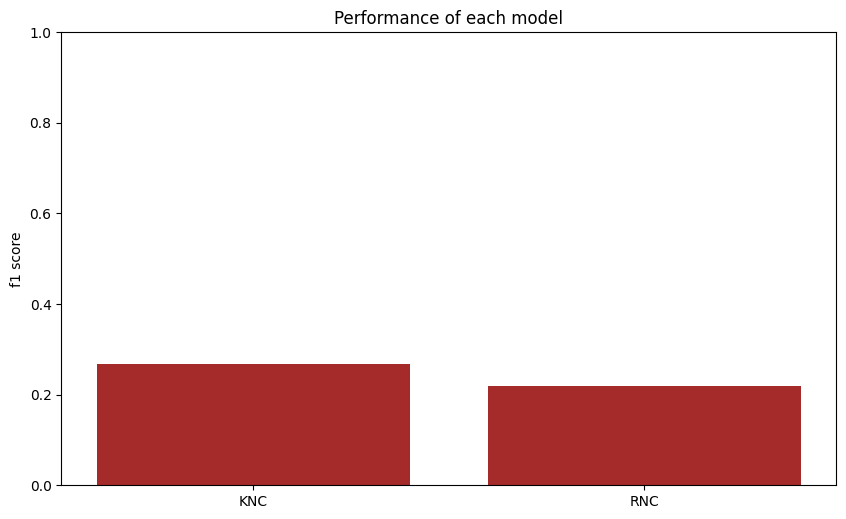

In [39]:
plt.figure(figsize=(10,6), dpi=100)
plt.bar( models_full.keys(), scores.values(), color='brown' )
plt.ylim(0,1)
plt.ylabel('f1 score')
plt.title('Performance of each model')
plt.show()

In [40]:
best_score=0
for model in models_full.values():
    score=model[2]
    if score>=best_score:
        best_score=score
        best_model=model[4]

In [100]:
from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest=train_test_split(X,y,shuffle=True)
ypred=best_model.predict(xtest)
print( classification_report(ytest,ypred) )

              precision    recall  f1-score   support

           3       0.20      0.50      0.29         2
           4       0.00      0.00      0.00        14
           5       0.62      0.60      0.61       172
           6       0.58      0.61      0.60       161
           7       0.56      0.51      0.53        49
           8       0.33      0.50      0.40         2

    accuracy                           0.57       400
   macro avg       0.38      0.45      0.40       400
weighted avg       0.57      0.57      0.57       400



## storing best model

In [31]:
# dumping model into pickle file 
with open('wine_model.pickle', 'wb') as handle:
    pickle.dump(best_model, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [32]:
# getting model from pickle file
with open('wine_model.pickle', 'rb') as handle:
    model=pickle.load(handle)
    
print(model)

In [ ]:
# details of all models
with open('all_wine_models.pickle', 'wb') as handle:
    pickle.dump(models_full, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('all_wine_models.pickle', 'rb') as handle:
    all_models=pickle.load(handle)
    
print(all_models)

# Results

In [ ]:
# ## a dictionary of all model details 
# models_full={'LogReg':[model_lr,
#                        params_lr,
#                        0.30,
#                        {'logisticregression__C': 5, 'logisticregression__l1_ratio': None, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'saga'},
#                        LogisticRegression(C=5, max_iter=1000, n_jobs=-1, penalty='l1', solver='saga')
#                       ],
             
#              'DT':[model_dt,
#                    params_dt,
#                    0.29,
#                    {'decisiontreeclassifier__criterion': 'entropy', 'decisiontreeclassifier__max_depth': 7, 'decisiontreeclassifier__max_features': 0.5, 
#                     'decisiontreeclassifier__min_samples_leaf': 1, 'decisiontreeclassifier__min_samples_split': 4},
#                    DecisionTreeClassifier(criterion='entropy', max_depth=7, max_features=0.5,min_samples_split=4)
#                   ],
             
#              'RF':[model_rf,
#                    params_rf,
                   
#                   ],
             
#              'gradboost':[model_gb,
#                           params_gb,
#                           0.4,
#                           {'gradboost__criterion':'squared_error', 'gradboost__learning_rate':0.5, 'gradboost__max_depth':5, 'gradboost__max_features':'log2', 'gradboost__subsample':0.9},
#                           GradientBoostingClassifier(criterion='squared_error', learning_rate=0.5, max_depth=5, max_features='log2', subsample=0.9),
#                          ],
             
#              'svc':[model_svc,
#                     params_svc,
#                     0.3,
#                     {'svc__C': 100, 'svc__degree': 3, 'svc__gamma': 0.1, 'svc__kernel': 'poly'},
#                     SVC(C=100, gamma=0.1, kernel='poly')
#                    ],
             
#              'knc':[model_knc,
#                     params_knc,
#                     0.26,
#                     {'kneighborsclassifier__algorithm': 'auto', 'kneighborsclassifier__leaf_size': 1, 'kneighborsclassifier__n_neighbors': 2, 'kneighborsclassifier__p': 2,
#                      'kneighborsclassifier__weights': 'distance'},
#                     KNeighborsClassifier(leaf_size=1, n_jobs=-1, n_neighbors=2, weights='distance')
#                    ],
             
#              'rnc':[model_rnc,
#                     params_rnc,
#                     0.2201067205818662,
#                     {'radiusneighborsclassifier__algorithm': 'auto', 'radiusneighborsclassifier__leaf_size': 1, 'radiusneighborsclassifier__p': 1, 
#                      'radiusneighborsclassifier__radius': 14, 'radiusneighborsclassifier__weights': 'distance'},
#                     RadiusNeighborsClassifier(leaf_size=1, n_jobs=-1, p=1, radius=14,weights='distance')
#                    ]
             
#             }


## individiual 

In [33]:
# X=wine.drop('quality',axis=1)
# y=wine.quality

# from sklearn.model_selection import train_test_split 
# xtrain,xtest,ytrain,ytest=train_test_split(X,y,shuffle=True)

# pipeline=make_pipeline(QuantileTransformer(n_quantiles=1000,output_distribution='normal'),
#                        MinMaxScaler(),
#                        DecisionTreeClassifier(),
#                       )

# ypred=pipeline.fit(xtrain,ytrain).predict(xtest)

# f1_score(ytest,ypred,average='macro')